<a href="https://colab.research.google.com/github/KLeeDE/Data-Science/blob/master/Second_Kay_NYC_business_census_data_ver2_ipyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [169]:
!pip install census
!pip install CensusData
!pip install us
!apt install libspatialindex-c4v5
!pip install pysal
#  geopandas myst be imported after rtree is installed
!apt install python3-rtree
!pip install geopandas

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-c4v5 is already the newest version (1.8.5-5).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


In [170]:
import pandas as pd
import os
import geopandas as gpd
from geopandas import GeoDataFrame

import matplotlib.pyplot as plt
from numpy import math
import numpy as np
import censusdata
from census import Census
from us import states
import pysal as ps


import numpy as np
import pylab as pl
import sklearn.cluster
import os
import urllib
%pylab inline
pl.style.use('ggplot')
from sklearn.cluster import KMeans

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['shape']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [171]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#1. Find the number of businesses in 2010 and 2000. This information is available at the zipcode level (see helper notebook in this repo NYC_business_census_data.ipynb and DATA.md)


In [172]:

# Download 2000 business data.
!wget ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip

# Download 2010 business data.
!wget ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip

--2020-11-22 02:23:58--  ftp://ftp.census.gov/Econ2001_And_Earlier/CBP_CSV/zbp00totals.zip
           => ‘zbp00totals.zip.9’
Resolving ftp.census.gov (ftp.census.gov)... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov (ftp.census.gov)|148.129.75.35|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Econ2001_And_Earlier/CBP_CSV ... done.
==> SIZE zbp00totals.zip ... 628434
==> PASV ... done.    ==> RETR zbp00totals.zip ... done.
Length: 628434 (614K) (unauthoritative)

zbp00totals.zip.9   100%[===================>] 613.71K  2.09MB/s    in 0.3s    

2020-11-22 02:24:00 (2.09 MB/s) - ‘zbp00totals.zip.9’ saved [628434]

--2020-11-22 02:24:00--  ftp://ftp.census.gov/econ2010/CBP_CSV/zbp10totals.zip
           => ‘zbp10totals.zip.9’
Resolving ftp.census.gov (ftp.census.gov)... 148.129.75.35, 2610:20:2010:a09:1000:0:9481:4b23
Connecting to ftp.census.gov (ftp.census.gov)|148.129.75.3

In [173]:

# Unzip business data.

!unzip zbp00totals.zip 
!unzip zbp10totals.zip 



Archive:  zbp00totals.zip
replace zbp00totals.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: zbp00totals.txt         
Archive:  zbp10totals.zip
replace zbp10totals.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: zbp10totals.txt         


In [174]:

# Load data to pandas dataframes.
df00 = pd.read_csv('zbp00totals.txt', 
                   usecols=['ZIP', 'NAME', 'EST'])
df10 = pd.read_csv('zbp10totals.txt', 
                   usecols=['zip', 'name', 'est'])

# Rename columns in 2000 data.
df00.rename(columns={'NAME': 'name', 'ZIP': 'zip', 'EST': 'est'}, 
            inplace=True)

# Remove data outside of NY.
df00 = df00[df00.name.str[-2:] == 'NY']
df10 = df10[df10.name.str[-2:] == 'NY']

# Convert 'zip' to string.
df00['zip'] = df00['zip'].map(lambda x: "%05d"%x)
df10['zip'] = df10['zip'].map(lambda x: "%05d"%x)

# Set zip to index.
df00.set_index('zip', inplace=True)
df10.set_index('zip', inplace=True)

# Join business data on zip index.
biz = df00.join(df10, how='outer', lsuffix='2000', rsuffix='2010')

# Clean up dataframe columns.
biz.drop('name2010', axis=1, inplace=True)
biz.rename(columns={'name2000': 'name'}, inplace=True)
biz['est2000'] = biz.est2000.astype(float)

biz.sort_index().head(2), biz.sort_index().tail(2)

(                     name  est2000  est2010
 zip                                        
 00501      HOLTSVILLE, NY      1.0      2.0
 06390  FISHERS ISLAND, NY     38.0     40.0,
              name  est2000  est2010
 zip                                
 14904  ELMIRA, NY    216.0    199.0
 14905  ELMIRA, NY    121.0    105.0)

In [175]:
biz

,name,est2000,est2010
zip,,,
00501,"HOLTSVILLE, NY",1.0,2.0
06390,"FISHERS ISLAND, NY",38.0,40.0
10001,"NEW YORK, NY",7317.0,7241.0
10002,"NEW YORK, NY",2277.0,2872.0
10003,"NEW YORK, NY",3683.0,4113.0
...,...,...,...
14901,"ELMIRA, NY",541.0,486.0
14902,"ELMIRA, NY",46.0,25.0
14903,"ELMIRA, NY",265.0,254.0


# 2. Gather a zipcode shapefile and merge the number of businesses with the zipcode shapfile so as to obtain a geodataframe

In [176]:
geo = gpd.read_file("/content/drive/My Drive/pus2020/ZIP_CODE_040114/ZIP_CODE_040114.shp")
geo = geo[["ZIPCODE", "geometry"]]

In [177]:
geo

,ZIPCODE,geometry
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17..."
...,...,...
258,10310,"POLYGON ((950767.507 172848.969, 950787.510 17..."
259,11693,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
260,11249,"POLYGON ((995877.318 203206.075, 995968.511 20..."
261,10162,"POLYGON ((997731.761 219560.922, 997641.948 21..."


In [178]:
geobiz = geo.merge(biz, left_on = "ZIPCODE", right_on = "zip")

In [179]:
geobiz

,ZIPCODE,geometry,name,est2000,est2010
0,11436,"POLYGON ((1038098.252 188138.380, 1038141.936 ...","JAMAICA, NY",65.0,98.0
1,11213,"POLYGON ((1001613.713 186926.440, 1002314.243 ...","BROOKLYN, NY",477.0,675.0
2,11212,"POLYGON ((1011174.276 183696.338, 1011373.584 ...","BROOKLYN, NY",520.0,699.0
3,11225,"POLYGON ((995908.365 183617.613, 996522.848 18...","BROOKLYN, NY",417.0,580.0
4,11218,"POLYGON ((991997.113 176307.496, 992042.798 17...","BROOKLYN, NY",1161.0,1474.0
...,...,...,...,...,...
253,11414,"POLYGON ((1025670.681 184011.380, 1025872.813 ...","HOWARD BEACH, NY",445.0,438.0
254,10310,"POLYGON ((950767.507 172848.969, 950787.510 17...","STATEN ISLAND, NY",424.0,485.0
255,11249,"POLYGON ((995877.318 203206.075, 995968.511 20...",NaN,NaN,30.0
256,10162,"POLYGON ((997731.761 219560.922, 997641.948 21...","NEW YORK, NY",21.0,21.0


#3. Find the density of businesses by dividing the number of businesses by the area of the zipcode (remember the geospatial homeworkm HW3 and HW4 and the geospatial lab) and show them the density in a choroplath (a heatmap version of a geographical map where each zipcode (census tract later) is a different color based on the value of the feature you are mapping) for 2000 and 2010 (OPTIONALLY: also show the difference in business density between 2000 and 2010 in a map, this will help you make sure you are on the right track) - see notes on this in DATA.ipynb

In [180]:
geometry = geobiz.geometry.to_crs(epsg=2263)
area = geometry.area*3.58701e-8
geobiz["area"] = area
geobiz["logarea"] = np.log10(area)
geobiz = geobiz[geobiz["area"] >= 0.05]

In [181]:
geobiz["density2000"] = geobiz["est2000"]/area
geobiz["density2010"] = geobiz["est2010"]/area
geobiz["diff"] = geobiz["density2010"] - geobiz["density2000"]

/usr/local/lib/python3.6/dist-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [182]:
#geobiz["density2010"].hist()

In [183]:
area.min()

0.0003640727351209654

In [184]:
#fig, ax = plt.subplots(figsize=[10, 10])
#ax = geobiz.plot("logarea", ax = ax)

#ax.set_xlim(0.975*1e6, 1e6)
#ax.set_ylim(195000, 220000)

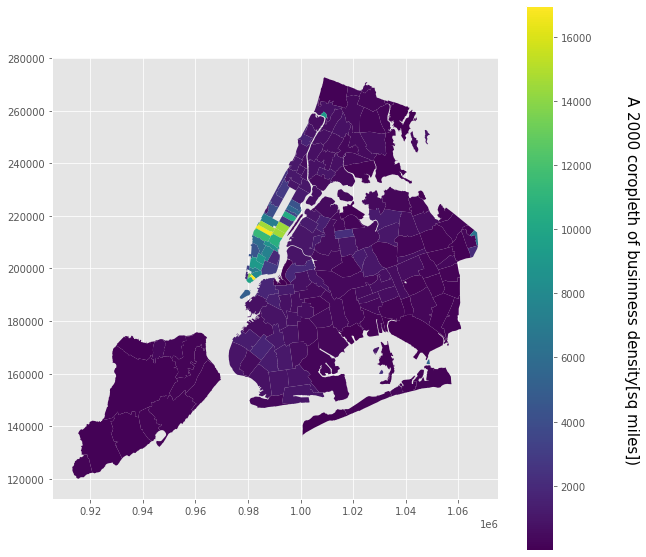

In [185]:
# -- make a choropleth
fig, ax = plt.subplots(figsize=[10, 10])
geobiz.plot("density2010", legend=True, ax=ax) 

fig.text(0.93, 0.5, "A 2000 coropleth of businness density[sq miles])", ha="center", 
      va="center", rotation=-90, fontsize=15)
fig.show()

figure caption: the above figure shows  2000 business density in NYC [sq miles]. It indicates that the midtown manhattan has the highest business density(above 12000), and then followed by lower manhattan. It indicates that most of the businenss clustered in midtown and lower manhattan.

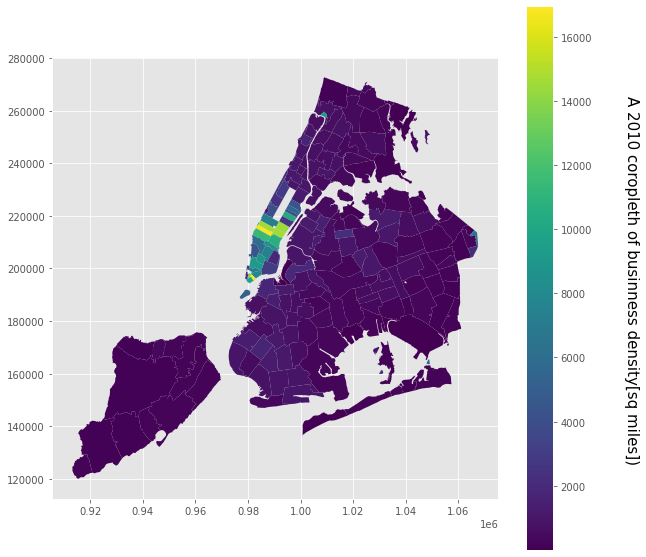

In [186]:
# -- make a choropleth
fig, ax = plt.subplots(figsize=[10, 10])
geobiz.plot("density2010", legend=True, ax=ax) 

fig.text(0.93, 0.5, "A 2010 coropleth of businness density[sq miles])", ha="center", 
      va="center", rotation=-90, fontsize=15)
fig.show()

figure caption: the above figure shows 2010 business density in NYC [sq miles]. It indicates that the midtown manhattan has the highest business density(above 12000), and then followed by lower manhattan. It indicates that most of the businenss clustered in midtown and lower manhattan.

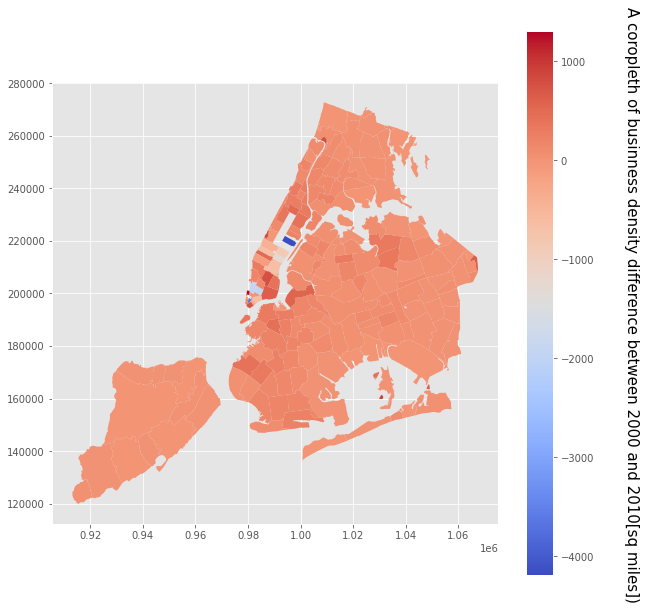

In [187]:
# -- make a choropleth
fig, ax = plt.subplots(figsize=[10, 10])
geobiz.plot("diff", legend=True, ax=ax, cmap="coolwarm") 

fig.text(0.93, 0.5, "A coropleth of businness density difference between 2000 and 2010[sq miles])", ha="center", 
      va="center", rotation=-90, fontsize=15)
fig.show()

figure caption: the above figure shows the difference of business dennsity between 2000 to 2010. It indicates that for most of the part, 2010 business density is higher than 2000 business density. However, there are two clear clusters has negative businenss difference. One is around central park, the other is in the lower manhattan. 

"Find the density of businesses by dividing the number of businesses by the area of the zipcode (remember the geospatial homeworkm HW3 and HW4 and the geospatial lab) and show them the density in a choroplath (a heatmap version of a geographical map where each zipcode (census tract later) is a different color based on the value of the feature you are mapping) for 2000 and 2010 (OPTIONALLY: also show the difference in business density between 2000 and 2010 in a map, this will help you make sure you are on the right track) - see notes on this in DATA.ipynb"

#4. Collect census data from the 2010 and 2000 census and extract the estimate (mean or median) age, population, and diversity of each census tract for all 5 NYC boroughs. The diversity (or lack thereof) can be measured by the fraction of white population.

(Borough = County)

Bronx = Bronx county

Brooklyn = Kings County

Manhattan = New York County

Queens = Queens County

Staten Island = Richmond County

In [188]:
# 2000 data

# Read raw data
census00 = pd.read_csv("/content/drive/MyDrive/pus2020/dec_00_sf1_dp1.csv")
# set column names 
census00_sub = census00[['geo_id2', 'geo_display_label', 'hc01_vc01', 'hc01_vc18', 'hc02_vc48']]
census00_sub.rename(columns = {'geo_id2': 'id', 'geo_display_label': 'label', 'hc01_vc01': 'Population', 'hc01_vc18': 'MedianAge', 'hc02_vc48': 'PercWhite'}, inplace=True)
# fill n/a
census00_sub = census00_sub.fillna(0)
# set new columns
census00_sub["PercNotWhite"] = 100 - census00_sub.PercWhite
#census00_sub["ctract_id"] = census00_sub.id.astype(str).str.slice(start=5, stop=11)
#census00_sub["ctract_id2"] = census00_sub.id.astype(str).str.slice(start=6, stop=11)
# set 5 boroughs
bronx00 = census00_sub.loc[census00_sub["label"].str.contains("Bronx")]
kings00 = census00_sub.loc[census00_sub["label"].str.contains("Kings")]
nycounty00 = census00_sub.loc[census00_sub["label"].str.contains("New York County")]
queens00 = census00_sub.loc[census00_sub["label"].str.contains("Queens")]
richm00 = census00_sub.loc[census00_sub["label"].str.contains("Richmond")]
census00_sub = pd.concat([bronx00, kings00, nycounty00, queens00, richm00])

# print
census00_sub["id"] = census00_sub["id"].astype(str)
census00_sub

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,label,Population,MedianAge,PercWhite,PercNotWhite
2,36005003700,"Census Tract 37, Bronx County, New York",478,22.0,20.7,79.3
3,36005004900,"Census Tract 49, Bronx County, New York",246,30.0,25.6,74.4
4,36005005800,"Census Tract 58, Bronx County, New York",5,23.5,0.0,100.0
5,36005017100,"Census Tract 171, Bronx County, New York",3,47.5,0.0,100.0
6,36005018700,"Census Tract 187, Bronx County, New York",33,37.3,24.2,75.8
...,...,...,...,...,...,...
3965,36085030301,"Census Tract 303.01, Richmond County, New York",4836,34.4,71.5,28.5
3966,36085030302,"Census Tract 303.02, Richmond County, New York",6125,31.3,58.8,41.2
3967,36085031901,"Census Tract 319.01, Richmond County, New York",3262,23.0,18.8,81.2
3968,36085031902,"Census Tract 319.02, Richmond County, New York",4130,27.2,26.3,73.7


In [189]:
# 2010 data

# Read raw data
census10 = pd.read_csv("/content/drive/MyDrive/pus2020/dec_10_sf1_sf1dp1.csv")
# set column names 
census10_sub = census10[['geo_id2', 'geo_display_label', 'hd01_s001', 'hd01_s020', 'hd02_s100']]
census10_sub.rename(columns = {'geo_id2': 'id', 'geo_display_label': 'label', 'hd01_s001': 'Population', 'hd01_s020': 'MedianAge', 'hd02_s100': 'PercWhite'}, inplace=True)
# fill n/a
census10_sub = census10_sub.fillna(0)
# set new columns
census10_sub["PercNotWhite"] = 100 - census10_sub.PercWhite
#census10_sub["ctract_id"] = census10_sub.id.astype(str).str.slice(start=5, stop=11)
# set 5 boroughs
bronx10 = census10_sub.loc[census10_sub["label"].str.contains("Bronx")]
kings10 = census10_sub.loc[census10_sub["label"].str.contains("Kings")]
nycounty10 = census10_sub.loc[census10_sub["label"].str.contains("New York County")]
queens10 = census10_sub.loc[census10_sub["label"].str.contains("Queens")]
richm10 = census10_sub.loc[census10_sub["label"].str.contains("Richmond")]
census10_sub = pd.concat([bronx10, kings10, nycounty10, queens10, richm10])

# print
census10_sub["id"] = census10_sub["id"].astype(str)
census10_sub

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,id,label,Population,MedianAge,PercWhite,PercNotWhite
1,36005002400,"Census Tract 24, Bronx County, New York",4,38.0,50.0,50.0
41,36005016300,"Census Tract 163, Bronx County, New York",0,0.0,0.0,100.0
42,36005031900,"Census Tract 319, Bronx County, New York",751,20.5,70.6,29.4
80,36005024900,"Census Tract 249, Bronx County, New York",0,0.0,0.0,100.0
106,36005050400,"Census Tract 504, Bronx County, New York",39,41.8,41.0,59.0
...,...,...,...,...,...,...
3964,36085030301,"Census Tract 303.01, Richmond County, New York",4929,36.6,62.7,37.3
3965,36085030302,"Census Tract 303.02, Richmond County, New York",6369,33.7,48.2,51.8
3966,36085031901,"Census Tract 319.01, Richmond County, New York",3265,27.7,21.2,78.8
3967,36085031902,"Census Tract 319.02, Richmond County, New York",4848,28.0,23.3,76.7


In [190]:
census00_sub.describe()

,Population,MedianAge,PercWhite,PercNotWhite
count,2217.000000,2217.000000,2217.000000,2217.000000
mean,3612.213802,34.135047,47.010104,52.989896
std,2463.233142,7.033842,31.451245,31.451245
min,0.000000,0.000000,0.000000,0.000000
25%,1916.000000,30.500000,18.900000,22.900000
50%,3149.000000,34.100000,44.900000,55.100000
75%,4675.000000,37.700000,77.100000,81.100000
max,24523.000000,87.200000,100.000000,100.000000


In [191]:
print("Mean of the 2000 population is {0:.2f}".format(census00_sub["Population"].mean()))
print("Mean of the 2000 medain age is {0:.2f}".format(census00_sub["MedianAge"].mean()))
print("Mean of the 2000 percentage of not-white is {0:.2f}".format(census00_sub["PercNotWhite"].mean()))

Mean of the 2000 population is 3612.21
Mean of the 2000 medain age is 34.14
Mean of the 2000 percentage of not-white is 52.99


In [192]:
census10_sub.describe()

,Population,MedianAge,PercWhite,PercNotWhite
count,2168.000000,2168.000000,2168.000000,2168.000000
mean,3770.817804,35.678321,45.347878,54.652122
std,2178.134903,7.475306,29.752529,29.752529
min,0.000000,0.000000,0.000000,0.000000
25%,2256.750000,32.000000,19.500000,26.875000
50%,3426.000000,35.500000,42.050000,57.950000
75%,4814.000000,39.400000,73.125000,80.500000
max,26588.000000,84.500000,100.000000,100.000000


In [193]:
print("Mean of the 2010 population is {0:.2f}".format(census10_sub["Population"].mean()))
print("Mean of the 2010 medain age is {0:.2f}".format(census10_sub["MedianAge"].mean()))
print("Mean of the 2010 percentage of not-white is {0:.2f}".format(census10_sub["PercNotWhite"].mean()))

Mean of the 2010 population is 3770.82
Mean of the 2010 medain age is 35.68
Mean of the 2010 percentage of not-white is 54.65


#5. Collect the income data by census tract from the income from American Fact Finder for the years 2010 and 2000 at the census tract level.

2000 & 2010 American Community Survey 1-Year Data

the first release of documentation in support of the 2019 American Community Survey 1-year estimates scheduled for release on Thursday, September 17, 2020. 

[Code Lists, Definitions, and Accuracy]("https://www.census.gov/programs-surveys/acs/technical-documentation/code-lists.html")

Uniuted States Census Bureau: https://data.census.gov/cedsci/

* First: get a census API key - you have to request it by email: 
https://api.census.gov/data/key_signup.html
* HW4: create a csv file called myapis.csv and upload it on your google drive in the main folder (My Drive). The code I shared as a skeleton notebook will read it in and your API key will be known in the notebook solong as you call it myapis.csv.


## 2010 Household Income Data

In [194]:
cd /content/drive/My Drive

/content/drive/My Drive


In [195]:
pwd

'/content/drive/My Drive'

In [196]:
myAPIkey =  pd.read_csv("myapi_20201116.csv")["census"]
c = Census(myAPIkey)

In [197]:
# Find the data
censusdata.censustable('acs5', 2010, 'B19013')
#censusdata.geographies(censusdata.censusgeo([('state', '36'), ('county', '005'), ('tract', '*')]), 'acs5', 2010)

OrderedDict([('B19013_001E',
              {'concept': 'B19013.  Median Household Income',
               'label': 'Median household income in the past 12 months (in 2010 inflation-adjusted dollars)',
               'predicateType': 'int'}),
             ('B19013_001M',
              {'concept': 'B19013.  Median Household Income',
               'label': 'Margin Of Error For!!Median household income in the past 12 months (in 2010 inflation-adjusted dollars)',
               'predicateType': 'int'})])

In [198]:
#Bronx county (bronx10) number is 005
bronx_income10 = censusdata.download('acs5', 2010, censusdata.censusgeo([('state', '36'), ('county', '005'), ('tract', '*')]), ["B19013_001E"])
#Brooklyn county (kings10) number is 047
kings_income10 = censusdata.download('acs5', 2010, censusdata.censusgeo([('state', '36'), ('county', '047'), ('tract', '*')]), ["B19013_001E"])
#Manhattan county (nycounty10) number is 061
nycounty_income10 = censusdata.download('acs5', 2010, censusdata.censusgeo([('state', '36'), ('county', '061'), ('tract', '*')]), ["B19013_001E"])
#Queens county (queens10) number is 081
queens_income10 = censusdata.download('acs5', 2010, censusdata.censusgeo([('state', '36'), ('county', '081'), ('tract', '*')]), ["B19013_001E"])
#Staten Island (richm10) number is 085
richm_income10 = censusdata.download('acs5', 2010, censusdata.censusgeo([('state', '36'), ('county', '085'), ('tract', '*')]), ["B19013_001E"])

In [199]:
income10 = pd.concat([bronx_income10, kings_income10, nycounty_income10, queens_income10, richm_income10])
income10["median_income"] = income10["B19013_001E"].clip(0,1e9).dropna()

In [200]:
def borough(cname):
  return cname.split(', ')[1].split(' County,')[0]
income10["borough"] = income10.index.astype(str).map(borough)

In [201]:
def state(cname):
  return cname.split(', state:')[1].split('>')[0]
income10["state"] = income10.index.astype(str).map(state)

def county(cname):
  return cname.split('county:')[1].split('>')[0]
income10["county"] = income10.index.astype(str).map(county)

def tract(cname):
  return cname.split('tract:')[1]
income10["tract"] = income10.index.astype(str).map(tract)

income10["geoid"] = income10["state"] + income10["county"] + income10["tract"]
income10 = income10[["median_income", "geoid", "borough"]]
income10

,median_income,geoid,borough
"Census Tract 215.02, Bronx County, New York: Summary level: 140, state:36> county:005> tract:021502",24181,36005021502,Bronx County
"Census Tract 216.01, Bronx County, New York: Summary level: 140, state:36> county:005> tract:021601",26016,36005021601,Bronx County
"Census Tract 216.02, Bronx County, New York: Summary level: 140, state:36> county:005> tract:021602",46672,36005021602,Bronx County
"Census Tract 217, Bronx County, New York: Summary level: 140, state:36> county:005> tract:021700",17722,36005021700,Bronx County
"Census Tract 218, Bronx County, New York: Summary level: 140, state:36> county:005> tract:021800",33131,36005021800,Bronx County
...,...,...,...
"Census Tract 303.02, Richmond County, New York: Summary level: 140, state:36> county:085> tract:030302",75724,36085030302,Richmond County
"Census Tract 319.01, Richmond County, New York: Summary level: 140, state:36> county:085> tract:031901",30492,36085031901,Richmond County
"Census Tract 319.02, Richmond County, New York: Summary level: 140, state:36> county:085> tract:031902",44412,36085031902,Richmond County
"Census Tract 323, Richmond County, New York: Summary level: 140, state:36> county:085> tract:032300",27600,36085032300,Richmond County


## 2000 Household Income Data

In [202]:
# read 2000 income data
bx00 = pd.read_csv("/content/drive/MyDrive/pus2020/householdincome_2000/sf3incp1bx.csv", skiprows=5)
bk00 = pd.read_csv("/content/drive/MyDrive/pus2020/householdincome_2000/sf3incp1bk.csv", skiprows=5)
mn00 = pd.read_csv("/content/drive/MyDrive/pus2020/householdincome_2000/sf3incp1mn.csv", skiprows=5)
qn00 = pd.read_csv("/content/drive/MyDrive/pus2020/householdincome_2000/sf3incp1qn.csv", skiprows=5)
si00 = pd.read_csv("/content/drive/MyDrive/pus2020/householdincome_2000/sf3incp1si.csv", skiprows=5)

In [203]:
si00.columns

Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13',
       'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17',
       'Unnamed: 18', 'Unnamed: 19', 'Unnamed: 20', 'Unnamed: 21'],
      dtype='object')

In [204]:
# subset columnns
bx00 = bx00[["Unnamed: 1", "Unnamed: 2", "Unnamed: 20"]]
bk00 = bk00[["Unnamed: 1", "Unnamed: 2", "Unnamed: 20"]]
mn00 = mn00[["Unnamed: 1", "Unnamed: 2", "Unnamed: 20"]]
qn00 = qn00[["Unnamed: 1", "Unnamed: 2", "Unnamed: 20"]]
si00 = si00[["Unnamed: 1", "Unnamed: 2", "Unnamed: 20"]]

In [205]:
frames = [bx00, bk00, mn00, qn00, si00]
income00 =  pd.concat(frames)
income00.columns = ["borough", "census_tract", "median_income"]
# remove dollar and common sign
income00["census_tract"] = income00["census_tract"].astype(str)
income00['median_income'] = income00['median_income'].str.replace(',', '').str.replace('$', '').astype(int)

In [206]:
# keep all the cennsus tract data format same
tract00 = []
for i in range(len(income00)):
  if len(income00["census_tract"].iloc[i]) == 3:
    ct = "000" + income00["census_tract"].iloc[i]
  if len(income00["census_tract"].iloc[i]) == 4:
    ct = "00" + income00["census_tract"].iloc[i]
  if len(income00["census_tract"].iloc[i]) == 5:
    ct = "0" + income00["census_tract"].iloc[i]
  if len(income00["census_tract"].iloc[i]) == 6:
    ct = income00["census_tract"].iloc[i]
  tract00.append(ct)

income00["tract"] = tract00

In [207]:
# generate geoid
id00 = []
for i in range(len(income00)):
  if income00["borough"].iloc[i] == "Bronx":
    idi = "36005" + income00["tract"].iloc[i]
  if income00["borough"].iloc[i] == "Staten Island":
    idi = "36085" + income00["tract"].iloc[i]
  if income00["borough"].iloc[i] == "Manhattan":
    idi = "36061" + income00["tract"].iloc[i]
  if income00["borough"].iloc[i] == "Brooklyn":
    idi = "36047" + income00["tract"].iloc[i]
  if income00["borough"].iloc[i] == "Queens":
    idi= "36081" + income00["tract"].iloc[i]
  id00.append(idi)

income00["id"] = id00
   

In [208]:
income00

,borough,census_tract,median_income,tract,id
0,Bronx,100,0,000100,36005000100
1,Bronx,200,42539,000200,36005000200
2,Bronx,400,39013,000400,36005000400
3,Bronx,500,0,000500,36005000500
4,Bronx,1100,25588,001100,36005001100
...,...,...,...,...,...
105,Staten Island,30301,49962,030301,36085030301
106,Staten Island,30302,51867,030302,36085030302
107,Staten Island,31901,26821,031901,36085031901
108,Staten Island,31902,32234,031902,36085031902


In [209]:
# check length of geoid
idx = []
for i in range(len(income00)):
  income00["id"] = income00["id"].astype(str)
  if len(income00["id"].iloc[i]) == 11:
    idi = income00["id"]
    idx.append(idi)
len(idx)

2217

#6. Merge the census datasets for each year and show a the tables containing the relevant data: the features and whatever else you need to identify and plot the data

## 2010 Census data

In [210]:
data10 = census10_sub.merge(income10, left_on = "id", right_on="geoid")
data10.isnull().sum()
#data10["median_income"] = data10["median_income"].clip(lower=0)
data10

,id,label,Population,MedianAge,PercWhite,PercNotWhite,median_income,geoid,borough
0,36005002400,"Census Tract 24, Bronx County, New York",4,38.0,50.0,50.0,0,36005002400,Bronx County
1,36005016300,"Census Tract 163, Bronx County, New York",0,0.0,0.0,100.0,0,36005016300,Bronx County
2,36005031900,"Census Tract 319, Bronx County, New York",751,20.5,70.6,29.4,0,36005031900,Bronx County
3,36005024900,"Census Tract 249, Bronx County, New York",0,0.0,0.0,100.0,0,36005024900,Bronx County
4,36005050400,"Census Tract 504, Bronx County, New York",39,41.8,41.0,59.0,0,36005050400,Bronx County
...,...,...,...,...,...,...,...,...,...
2163,36085030301,"Census Tract 303.01, Richmond County, New York",4929,36.6,62.7,37.3,67431,36085030301,Richmond County
2164,36085030302,"Census Tract 303.02, Richmond County, New York",6369,33.7,48.2,51.8,75724,36085030302,Richmond County
2165,36085031901,"Census Tract 319.01, Richmond County, New York",3265,27.7,21.2,78.8,30492,36085031901,Richmond County
2166,36085031902,"Census Tract 319.02, Richmond County, New York",4848,28.0,23.3,76.7,44412,36085031902,Richmond County


## 2000 Census data 

In [211]:
income00["id"] = income00["id"].astype(str)
income00

,borough,census_tract,median_income,tract,id
0,Bronx,100,0,000100,36005000100
1,Bronx,200,42539,000200,36005000200
2,Bronx,400,39013,000400,36005000400
3,Bronx,500,0,000500,36005000500
4,Bronx,1100,25588,001100,36005001100
...,...,...,...,...,...
105,Staten Island,30301,49962,030301,36085030301
106,Staten Island,30302,51867,030302,36085030302
107,Staten Island,31901,26821,031901,36085031901
108,Staten Island,31902,32234,031902,36085031902


In [212]:
data00 = census00_sub.merge(income00, left_on = "id", right_on="id")
data00.isnull().sum()
data00["median_income"] = data00["median_income"].clip(lower=0)
data00

,id,label,Population,MedianAge,PercWhite,PercNotWhite,borough,census_tract,median_income,tract
0,36005003700,"Census Tract 37, Bronx County, New York",478,22.0,20.7,79.3,Bronx,3700,23750,003700
1,36005004900,"Census Tract 49, Bronx County, New York",246,30.0,25.6,74.4,Bronx,4900,25662,004900
2,36005005800,"Census Tract 58, Bronx County, New York",5,23.5,0.0,100.0,Bronx,5800,6250,005800
3,36005017100,"Census Tract 171, Bronx County, New York",3,47.5,0.0,100.0,Bronx,17100,0,017100
4,36005018700,"Census Tract 187, Bronx County, New York",33,37.3,24.2,75.8,Bronx,18700,0,018700
...,...,...,...,...,...,...,...,...,...,...
2212,36085030301,"Census Tract 303.01, Richmond County, New York",4836,34.4,71.5,28.5,Staten Island,30301,49962,030301
2213,36085030302,"Census Tract 303.02, Richmond County, New York",6125,31.3,58.8,41.2,Staten Island,30302,51867,030302
2214,36085031901,"Census Tract 319.01, Richmond County, New York",3262,23.0,18.8,81.2,Staten Island,31901,26821,031901
2215,36085031902,"Census Tract 319.02, Richmond County, New York",4130,27.2,26.3,73.7,Staten Island,31902,32234,031902


## Plot

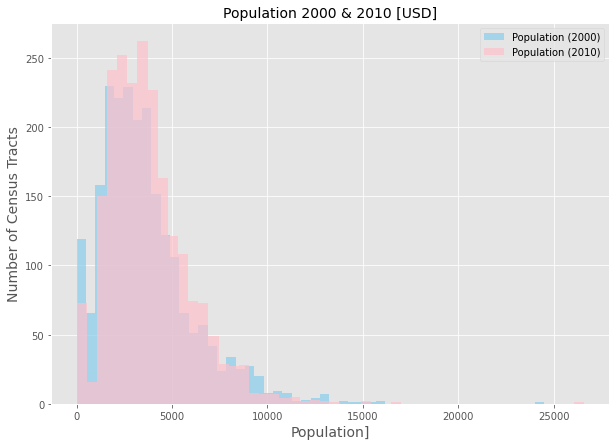

In [213]:
# Population
fig, ax = plt.subplots(figsize=[10,7])
ax.hist(data00["Population"], bins=50, color="skyblue", alpha=0.7, label="Population (2000)")
ax.hist(data10["Population"], bins=50, color="pink", alpha=0.7, label="Population (2010)")
ax.set_xlabel("Population]", fontsize=14)
ax.set_ylabel("Number of Census Tracts", fontsize=14)
plt.title("Population 2000 & 2010 [USD]", fontsize=14)
ax.legend()
fig.show()

Figure caption: the above histogram shows the distributionn of population in NYC, it indicates the population distribution in 2000 and 2010 were concenntrated between 0 to 50000. Overall, the 2010 population cluster between 0 to 5000 is higher than it in 2000.

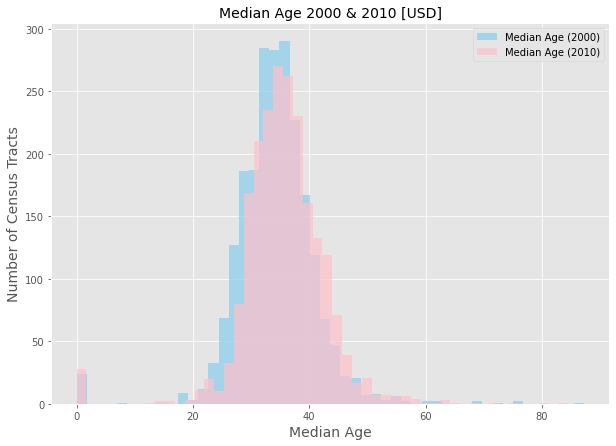

In [214]:
# Median age
fig, ax = plt.subplots(figsize=[10,7])
ax.hist(data00["MedianAge"], bins=50, color="skyblue", alpha=0.7, label="Median Age (2000)")
ax.hist(data10["MedianAge"], bins=50, color="pink", alpha=0.7, label="Median Age (2010)")
ax.set_xlabel("Median Age", fontsize=14)
ax.set_ylabel("Number of Census Tracts", fontsize=14)
plt.title("Median Age 2000 & 2010 [USD]", fontsize=14)
ax.legend()
fig.show()

Figure Caption: the above histogram shows the distributionn of mediann age in NYC. It shows that median age is concenntraated between 30 to 40 both in 2000 and 2010. Overall, the median age from 2000 to 2010 is increasng for each census tract. 

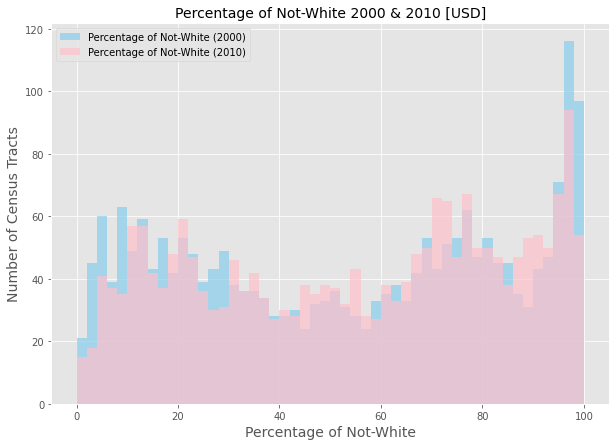

In [215]:
# Percentage Not White
fig, ax = plt.subplots(figsize=[10,7])
ax.hist(data00["PercNotWhite"], bins=50, color="skyblue", alpha=0.7, label="Percentage of Not-White (2000)")
ax.hist(data10["PercNotWhite"], bins=50, color="pink", alpha=0.7, label="Percentage of Not-White (2010)")
ax.set_xlabel("Percentage of Not-White", fontsize=14)
ax.set_ylabel("Number of Census Tracts", fontsize=14)
plt.title("Percentage of Not-White 2000 & 2010 [USD]", fontsize=14)
ax.legend()
fig.show()

Figure Caption: the above histogram shows the distributionn of percentage of not-white in NYC(2000 and 2010). It shows that the percentage of not-white varies from different census tract. Moreover, it does have some places has 0 or 100 not-white percentage both in 2000 and 2010.

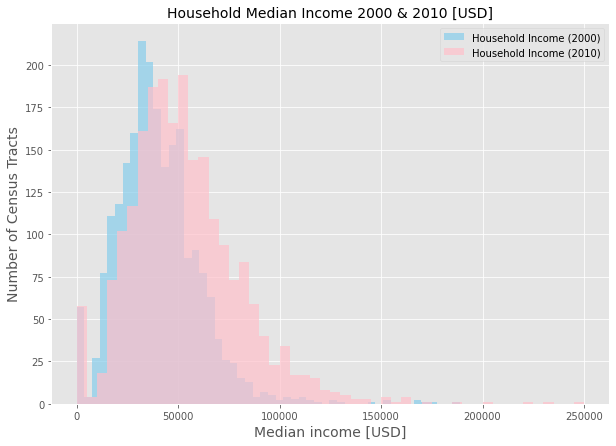

In [216]:
# Income
fig, ax = plt.subplots(figsize=[10,7])
ax.hist(data00["median_income"], bins=50, color="skyblue", alpha=0.7, label="Household Income (2000)")
ax.hist(data10["median_income"], bins=50, color="pink", alpha=0.7, label="Household Income (2010)")
ax.set_xlabel("Median income [USD]", fontsize=14)
ax.set_ylabel("Number of Census Tracts", fontsize=14)
plt.title("Household Median Income 2000 & 2010 [USD]", fontsize=14)
ax.legend()
fig.show()

Figure Caption: the above histogram shows the distributionn of household median income with unit USD in NYC(2000 and 2010). The household median income in 2010 is higher than it is in 2000 (between 35000 to 60000). 

In [217]:
pop00 = data00["Population"].groupby([data00.borough]).sum()
pop10 = data10["Population"].groupby([data10.borough]).sum()

age00 = data00["MedianAge"].groupby([data00.borough]).sum()
age10 = data10["MedianAge"].groupby([data10.borough]).sum()

notwhite00 = data00["PercNotWhite"].groupby([data00.borough]).sum()
notwhite10 = data10["PercNotWhite"].groupby([data10.borough]).sum()

inc00 = data00["median_income"].groupby([data00.borough]).sum()
inc10 = data10["median_income"].groupby([data10.borough]).sum()

Text(0.5, 0, 'Borough name')

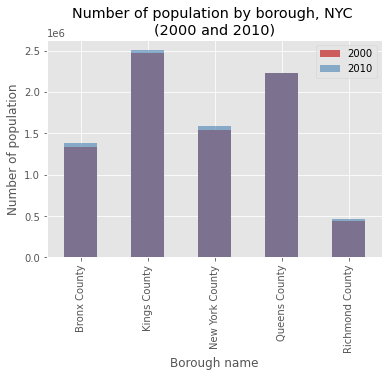

In [218]:
ax = pop00.plot(kind="bar", color = "IndianRed", label= "2000")
ax = pop10.plot(kind="bar", color = "SteelBlue", label= "2010", alpha = 0.6)
plt.legend();
plt.title("Number of population by borough, NYC \n(2000 and 2010)")
plt.ylabel("Number of population")
plt.xlabel("Borough name")

Figure Caption: the above figure shows the number of populationn by borough in NYC in 2010 are all higher than the number of populationn by borough in NYC in 2000.


Text(0.5, 0, 'Borough name')

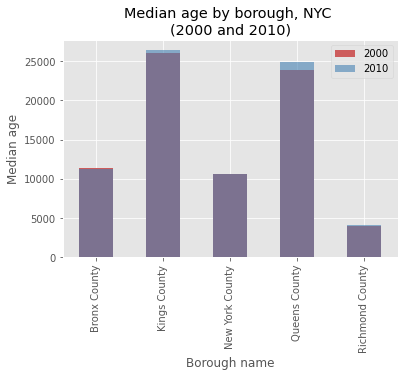

In [219]:
ax = age00.plot(kind="bar", color = "IndianRed", label= "2000")
ax = age10.plot(kind="bar", color = "SteelBlue", label= "2010", alpha = 0.6)
plt.legend();
plt.title("Median age by borough, NYC \n(2000 and 2010)")
plt.ylabel("Median age")
plt.xlabel("Borough name")

Figure Caption: the above figure shows the median age in four boroughs(Kings, New York, Queenns, Richmond) in NYC in 2010 is higher than it is in NYC in 2000. For the Bronx county, the median age in 2010 is smaller than it is in 2000.

Text(0.5, 0, 'Borough name')

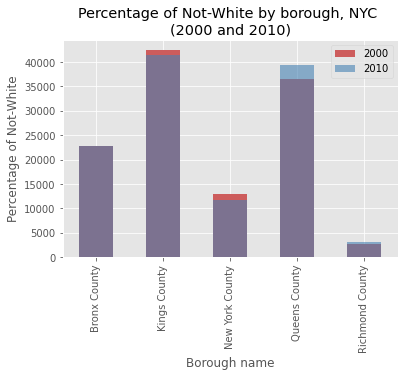

In [220]:
ax = notwhite00.plot(kind="bar", color = "IndianRed", label= "2000")
ax = notwhite10.plot(kind="bar", color = "SteelBlue", label= "2010", alpha = 0.6)
plt.legend();
plt.title("Percentage of Not-White by borough, NYC \n(2000 and 2010)")
plt.ylabel("Percentage of Not-White")
plt.xlabel("Borough name")

Figure Caption: the above figure shows the not-white percentage in Kings, annd New York in 2000 is higher than it is in 2010. For the Queenns, and Richmond, the not-white percentage in 2000 is smaller than it is in 2010. For the Bronx, they are almost same. 

#7. Merge the df with the census tracts shapefile so as to obtain a geodataframe (see DATA and HINTS files) and display each of your features as a choropleth for both 2010 and 2000, and show the difference in the features as a third choroplath.

In [221]:
!pip install geopandas

In [222]:
import geopandas as gp

In [223]:
ctract = gp.read_file("https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile")
ctract

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643..."
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((-73.96433 40.75638, -73.96479 40.755..."
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((-73.96802 40.75958, -73.96848 40.758..."
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760..."
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2160,4,4021200,Queens,I,021200,212,QN61,Jamaica,4112,2.536196e+06,8201.875265,"POLYGON ((-73.81153 40.70227, -73.81083 40.702..."
2161,4,4107201,Queens,I,107201,1072.01,QN10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,4114,1.553053e+07,35194.224948,"POLYGON ((-73.81653 40.61495, -73.81655 40.614..."
2162,4,4107202,Queens,I,107202,1072.02,QN99,park-cemetery-etc-Queens,4114,7.178839e+07,182384.827557,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
2163,5,5022600,Staten Island,I,022600,226,SI11,Charleston-Richmond Valley-Tottenville,3901,8.623340e+07,54954.350950,"POLYGON ((-74.20700 40.55757, -74.20880 40.557..."


In [224]:
ctract[ctract["boro_name"] == "Bronx"]

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
303,2,2003300,Bronx,E,003300,33,BX39,Mott Haven-Port Morris,3710,1.639978e+06,5957.066998,"POLYGON ((-73.91069 40.80881, -73.90976 40.808..."
304,2,2003500,Bronx,E,003500,35,BX39,Mott Haven-Port Morris,3710,1.525331e+06,5804.923407,"POLYGON ((-73.90725 40.81286, -73.90633 40.812..."
305,2,2003800,Bronx,E,003800,38,BX09,Soundview-Castle Hill-Clason Point-Harding Park,3709,6.821662e+05,3473.805854,"POLYGON ((-73.86246 40.81925, -73.86339 40.819..."
306,2,2004001,Bronx,E,004001,40.01,BX55,Soundview-Bruckner,3709,1.325276e+06,4916.715643,"POLYGON ((-73.85615 40.82677, -73.85636 40.826..."
307,2,2004400,Bronx,E,004400,44,BX55,Soundview-Bruckner,3709,2.884624e+06,8675.983180,"POLYGON ((-73.85970 40.82628, -73.86121 40.826..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2099,2,2015700,Bronx,E,015700,157,BX75,Crotona Park East,3705,3.366008e+06,8519.979556,"POLYGON ((-73.88223 40.83545, -73.88209 40.835..."
2108,2,2002300,Bronx,E,002300,23,BX39,Mott Haven-Port Morris,3710,1.126745e+06,4717.341842,"POLYGON ((-73.92289 40.80911, -73.92324 40.808..."
2109,2,2005100,Bronx,I,005100,51,BX39,Mott Haven-Port Morris,3710,5.506772e+06,13393.818469,"POLYGON ((-73.92518 40.81801, -73.92622 40.816..."
2138,2,2038000,Bronx,E,038000,380,BX44,Williamsbridge-Olinville,3702,2.346733e+06,6160.393891,"POLYGON ((-73.85861 40.87892, -73.85892 40.878..."


In [225]:
# - Set geoid

ctract["state"] = 36

#Bronx county (bronx10) number is 005 / boro_code is 2
#Brooklyn county (kings10) number is 047 / boro_code is 3
#Manhattan county (nycounty10) number is 061 / boro_code is 1
#Queens county (queens10) number is 081 / boro_code is 4
#Staten Island (richm10) number is 085 / boro_code is 5
ctract["county"] = ctract.boro_code.replace("2", "005").replace("3", "047").replace("1", "061").replace("4", "081").replace("5", "085")

ctract["state"] = ctract["state"].astype(str)
ctract["county"] = ctract["county"].astype(str)
ctract["tract"] = ctract["ct2010"].astype(str)

ctract["id"] = ctract["state"] + ctract["county"] + ctract["tract"]
ctract["id"] = ctract["id"].astype(str)
ctract

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry,state,county,tract,id
0,5,5000900,Staten Island,E,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((-74.07921 40.64343, -74.07914 40.643...",36,085,000900,36085000900
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((-73.96433 40.75638, -73.96479 40.755...",36,061,009800,36061009800
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((-73.96802 40.75958, -73.96848 40.758...",36,061,010000,36061010000
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((-73.97124 40.76094, -73.97170 40.760...",36,061,010200,36061010200
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,"POLYGON ((-73.97446 40.76229, -73.97491 40.761...",36,061,010400,36061010400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2160,4,4021200,Queens,I,021200,212,QN61,Jamaica,4112,2.536196e+06,8201.875265,"POLYGON ((-73.81153 40.70227, -73.81083 40.702...",36,081,021200,36081021200
2161,4,4107201,Queens,I,107201,1072.01,QN10,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,4114,1.553053e+07,35194.224948,"POLYGON ((-73.81653 40.61495, -73.81655 40.614...",36,081,107201,36081107201
2162,4,4107202,Queens,I,107202,1072.02,QN99,park-cemetery-etc-Queens,4114,7.178839e+07,182384.827557,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...",36,081,107202,36081107202
2163,5,5022600,Staten Island,I,022600,226,SI11,Charleston-Richmond Valley-Tottenville,3901,8.623340e+07,54954.350950,"POLYGON ((-74.20700 40.55757, -74.20880 40.557...",36,085,022600,36085022600


In [226]:
# generate geoid
geoid = []
for i in range(len(ctract)):
  if ctract["boro_name"].iloc[i] == "Bronx":
    idi = "36005" + ctract["ct2010"].iloc[i]
  if ctract["boro_name"].iloc[i] == "Staten Island":
    idi = "36085" + ctract["ct2010"].iloc[i]
  if ctract["boro_name"].iloc[i] == "Manhattan":
    idi = "36061" + ctract["ct2010"].iloc[i]
  if ctract["boro_name"].iloc[i] == "Brooklyn":
    idi = "36047" + ctract["ct2010"].iloc[i]
  if ctract["boro_name"].iloc[i] == "Queens":
    idi= "36081" + ctract["ct2010"].iloc[i]
  geoid.append(idi)

ctract["id"] = geoid

In [227]:
ctract_sub = ctract[["id", "geometry", "boro_name", "shape_area", "shape_leng"]]
ctract_sub

,id,geometry,boro_name,shape_area,shape_leng
0,36085000900,"POLYGON ((-74.07921 40.64343, -74.07914 40.643...",Staten Island,2.497010e+06,7729.016794
1,36061009800,"POLYGON ((-73.96433 40.75638, -73.96479 40.755...",Manhattan,1.906016e+06,5534.199811
2,36061010000,"POLYGON ((-73.96802 40.75958, -73.96848 40.758...",Manhattan,1.860938e+06,5692.168737
3,36061010200,"POLYGON ((-73.97124 40.76094, -73.97170 40.760...",Manhattan,1.860993e+06,5687.802439
4,36061010400,"POLYGON ((-73.97446 40.76229, -73.97491 40.761...",Manhattan,1.864600e+06,5693.036367
...,...,...,...,...,...
2160,36081021200,"POLYGON ((-73.81153 40.70227, -73.81083 40.702...",Queens,2.536196e+06,8201.875265
2161,36081107201,"POLYGON ((-73.81653 40.61495, -73.81655 40.614...",Queens,1.553053e+07,35194.224948
2162,36081107202,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...",Queens,7.178839e+07,182384.827557
2163,36085022600,"POLYGON ((-74.20700 40.55757, -74.20880 40.557...",Staten Island,8.623340e+07,54954.350950


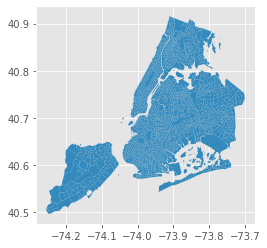

In [228]:
ctract.plot()

In [229]:
ctract_data00 = ctract_sub.merge(data00, left_on="id", right_on = "id")
ctract_data10 = ctract_sub.merge(data10, left_on="id", right_on = "id")

In [230]:
data_00to10 = data00.merge(data10, left_on="id", right_on = "id")
ctract_data_00to10 = ctract_sub.merge(data_00to10, left_on="id", right_on = "id")
ctract_data_00to10.columns

Index(['id', 'geometry', 'boro_name', 'shape_area', 'shape_leng', 'label_x',
       'Population_x', 'MedianAge_x', 'PercWhite_x', 'PercNotWhite_x',
       'borough_x', 'census_tract', 'median_income_x', 'tract', 'label_y',
       'Population_y', 'MedianAge_y', 'PercWhite_y', 'PercNotWhite_y',
       'median_income_y', 'geoid', 'borough_y'],
      dtype='object')

In [231]:
ctract_data_00to10["diff_Population"] = ctract_data_00to10["Population_y"] - ctract_data_00to10["Population_x"] 
ctract_data_00to10["diff_MedianAge"] = ctract_data_00to10["MedianAge_y"] - ctract_data_00to10["MedianAge_x"] 
ctract_data_00to10["diff_PercNotWhite"] = ctract_data_00to10["PercNotWhite_y"] - ctract_data_00to10["PercNotWhite_x"] 
ctract_data_00to10["diff_median_income"] = ctract_data_00to10["median_income_y"] - ctract_data_00to10["median_income_x"] 

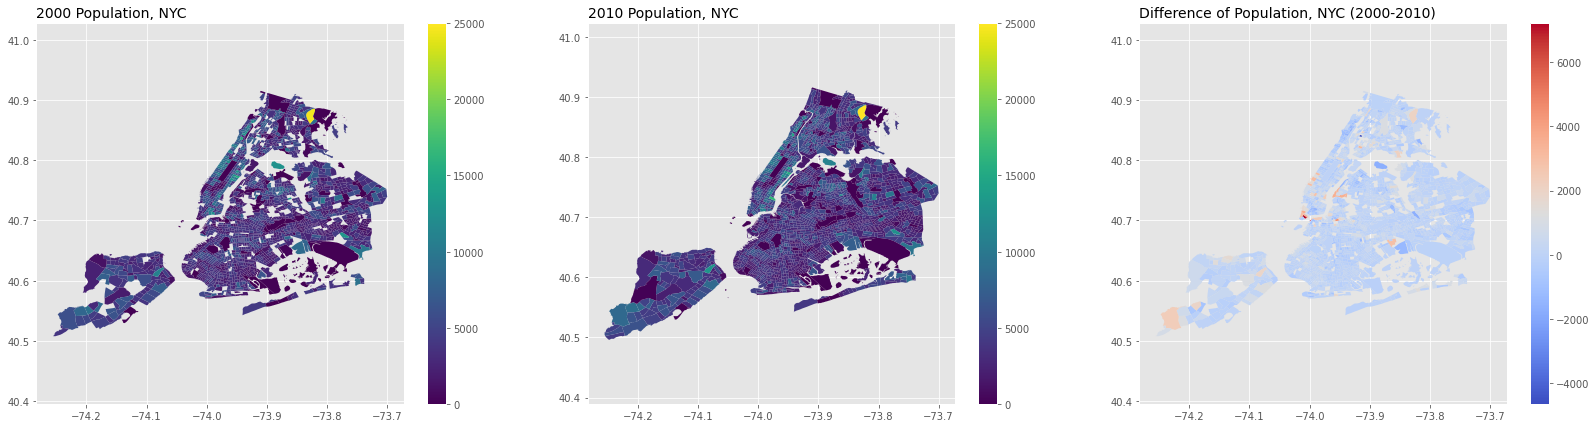

In [232]:
# Population
fig, ax = plt.subplots(1,3, figsize=[28,7])
plot0 = ax[0]
plot1 = ax[1]
plot2 = ax[2]

ctract_data00.plot("Population", legend=True, vmin=0, vmax=25000, ax=plot0)
ax[0].axis("equal")
ax[0].set_title("2000 Population, NYC", loc="left", fontsize=14)

ctract_data10.plot("Population", legend=True, vmin=0, vmax=25000, ax=plot1)
ax[1].axis("equal")
ax[1].set_title("2010 Population, NYC", loc="left", fontsize=14)

ctract_data_00to10.plot("diff_Population", legend=True, ax=plot2, cmap="coolwarm")
ax[2].axis("equal")
ax[2].set_title("Difference of Population, NYC (2000-2010)", loc="left", fontsize=14)

fig.show()

Figure Caption: from the left to the right, the 2000 population map inndicates that there is one census tract area in Bronx county has the highest number population(around 25000), then followed by most of the area in Manhattan and Staten islannd. The 2010 population map indicates that there is one census tract area in Bronx county has the highest number population, then followed by most of the area in Manhattan and Staten islannd. 

For the difference of population between 2000 to 2010, overall the population is decreasing. But for some area, such as lower manhattan, southwest of Staten Island, the population in 2010 is higher than it is in 2000.


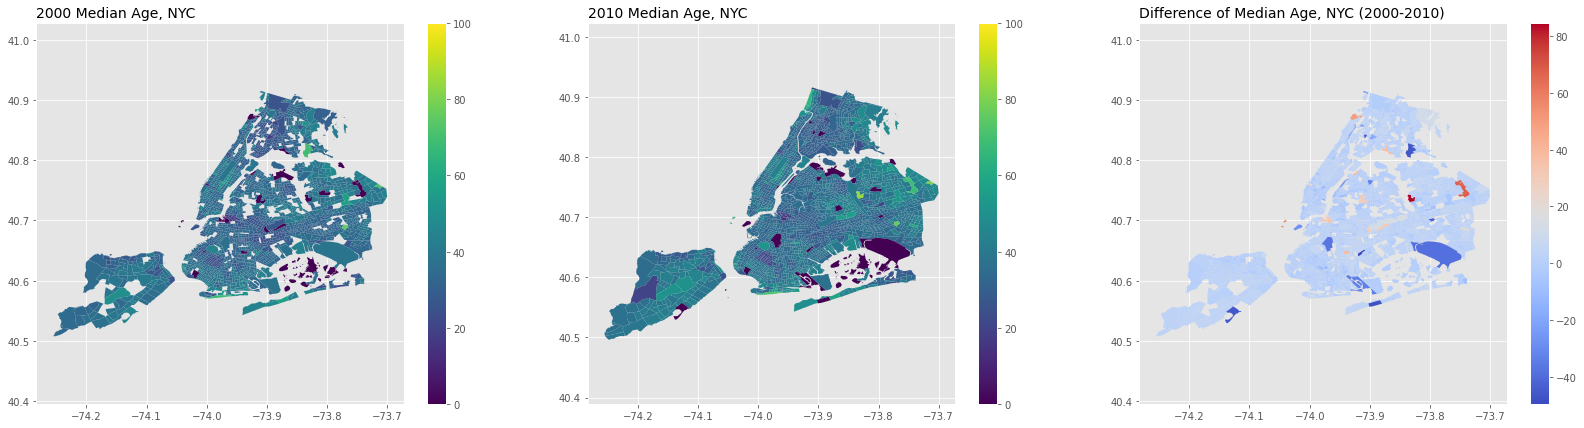

In [233]:
# Median Age
fig, ax = plt.subplots(1,3, figsize=[28,7])
plot0 = ax[0]
plot1 = ax[1]
plot2 = ax[2]

ctract_data00.plot("MedianAge", legend=True, vmin=0, vmax=100, ax=plot0)
ax[0].axis("equal")
ax[0].set_title("2000 Median Age, NYC", loc="left", fontsize=14)


ctract_data10.plot("MedianAge", legend=True, vmin=0, vmax=100, ax=plot1)
ax[1].axis("equal")
ax[1].set_title("2010 Median Age, NYC", loc="left", fontsize=14)


ctract_data_00to10.plot("diff_MedianAge", legend=True, ax=plot2, cmap="coolwarm")
ax[2].axis("equal")
ax[2].set_title("Difference of Median Age, NYC (2000-2010)", loc="left", fontsize=14)


fig.show()

Figure Caption: from the left to the right, the 2000 median age map inndicates that the mediann age in most of the area in nyc is aroud 40. The 2010 median age map indicates that overall the the mediann age in most of the area in nyc is aroud 40 but in some area in south of Queens, the median age is around 10. 

For the difference of median age between 2000 to 2010, overall the population is decreasing, especially for the south of Queens. 

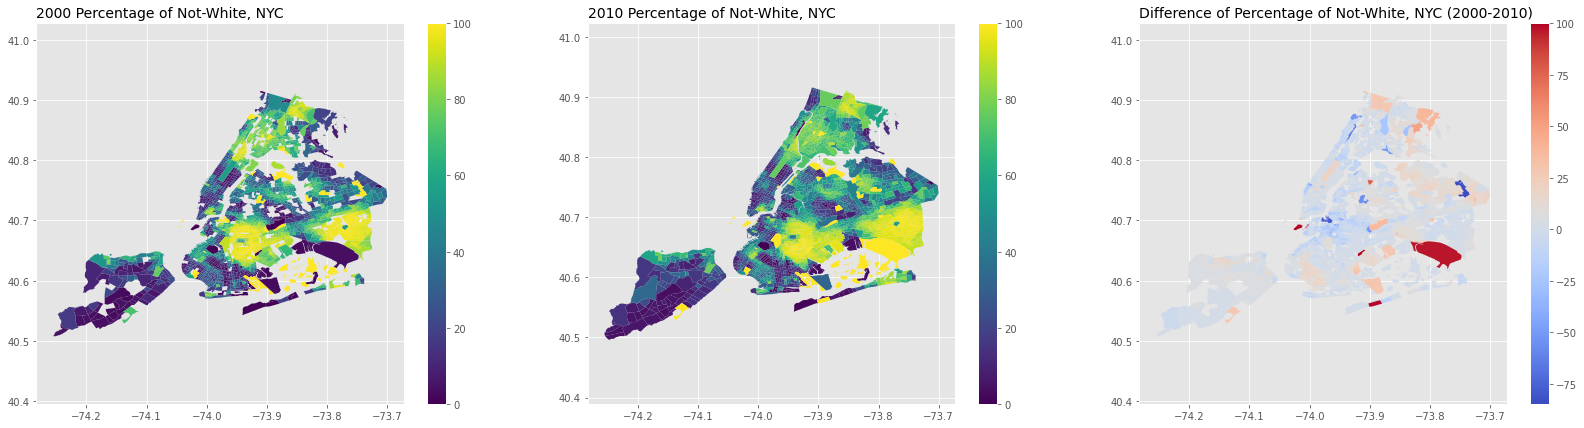

In [234]:
# Perc Not White
fig, ax = plt.subplots(1,3, figsize=[28,7])
plot0 = ax[0]
plot1 = ax[1]
plot2 = ax[2]

ctract_data00.plot("PercNotWhite", legend=True, vmin=0, vmax=100, ax=plot0)
ax[0].axis("equal")
ax[0].set_title("2000 Percentage of Not-White, NYC", loc="left", fontsize=14)


ctract_data10.plot("PercNotWhite", legend=True, vmin=0, vmax=100, ax=plot1)
ax[1].axis("equal")
ax[1].set_title("2010 Percentage of Not-White, NYC", loc="left", fontsize=14)


ctract_data_00to10.plot("diff_PercNotWhite", legend=True, ax=plot2, cmap="coolwarm")
ax[2].axis("equal")
ax[2].set_title("Difference of Percentage of Not-White, NYC (2000-2010)", loc="left", fontsize=14)



fig.show()

Figure Caption: from the left to the right, the 2000 percentage of not-white map inndicates that in Brooklyn, Queens, and Bronnx, the not-white percentage is higher. for the staten island, the not-white percentage is lower. The 2010 percentage of not-white map inndicates that in Brooklyn, Queens, and Bronnx, the not-white percentage is higher. for the staten island, the not-white percentage is lower. 

For the difference of not-white percentage between 2000 to 2010, overall the percentage is increasing, especially for the south of Queens.

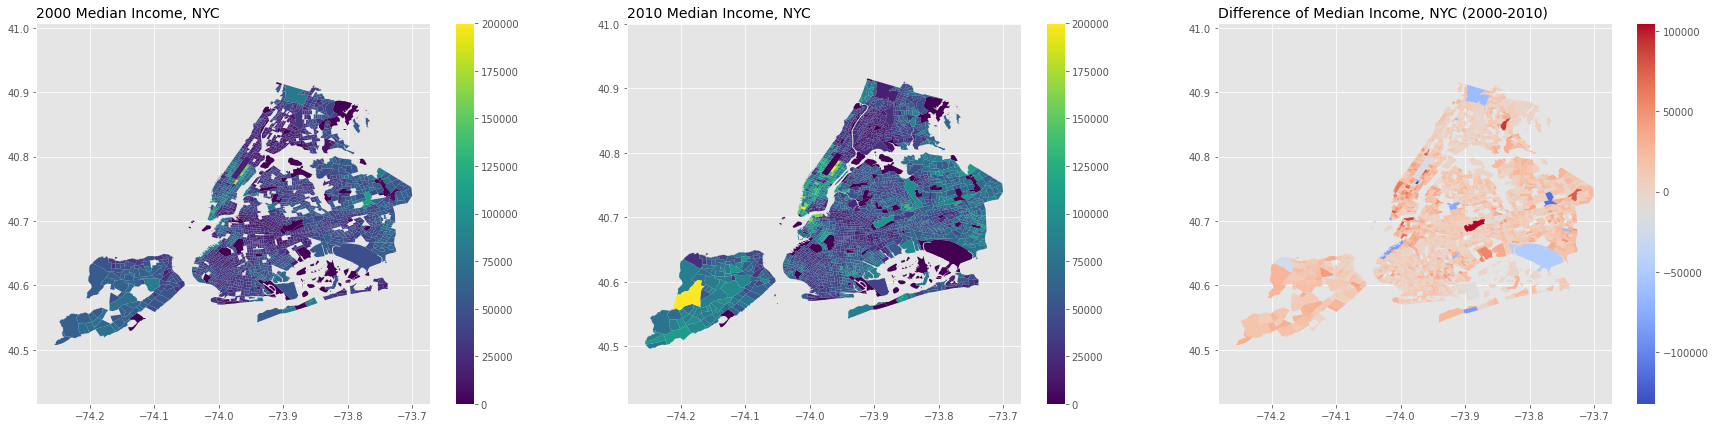

In [235]:
# Median Income
fig, ax = plt.subplots(1,3, figsize=[30,7])
plot0 = ax[0]
plot1 = ax[1]
plot2 = ax[2]

ctract_data00.plot("median_income", legend=True, vmin=0, vmax=200000, ax=plot0)
ax[0].axis("equal")
ax[0].set_title("2000 Median Income, NYC", loc="left", fontsize=14)


ctract_data10.plot("median_income", legend=True, vmin=0, vmax=200000, ax=plot1)
ax[1].axis("equal")
ax[1].set_title("2010 Median Income, NYC", loc="left", fontsize=14)


ctract_data_00to10.plot("diff_median_income", legend=True, ax=plot2, cmap="coolwarm")
ax[2].axis("equal")
ax[2].set_title("Difference of Median Income, NYC (2000-2010)", loc="left", fontsize=14)



fig.show()

Figure Caption: from the left to the right, the 2000 household median income map inndicates that manhattan has the highest median income, espically area arounnd central park. The 2010 household median income map inndicates that Staten Island has the highest median income.
For the difference of not-white percentage between 2000 to 2010, overall the household income is increasing.

#8. Aggregate the census four features at the zipcode level and merge the zipcode dataframe - see helper notebook spatial_joint_of_census_tracts_and_zipcode.ipynb

https://github.com/fedhere/PUS2020_FBianco/blob/master/HW11/spatial_joint_of_census_tracts_and_zipcode.ipynb


In [236]:
censustract = gpd.GeoDataFrame.from_file(
    "https://data.cityofnewyork.us/api/geospatial/" + 
    "fxpq-c8ku?method=export&format=GeoJSON")
censustract

,ntacode,shape_area,ntaname,shape_leng,boro_name,puma,ct2010,boro_code,cdeligibil,boro_ct2010,ctlabel,geometry
0,SI22,2497009.71359,West New Brighton-New Brighton-St. George,7729.01679383,Staten Island,3903,000900,5,E,5000900,9,"MULTIPOLYGON (((-74.07921 40.64343, -74.07914 ..."
1,MN19,1906016.35002,Turtle Bay-East Midtown,5534.19981063,Manhattan,3808,009800,1,I,1009800,98,"MULTIPOLYGON (((-73.96433 40.75638, -73.96479 ..."
2,MN19,1860938.37721,Turtle Bay-East Midtown,5692.16873705,Manhattan,3808,010000,1,I,1010000,100,"MULTIPOLYGON (((-73.96802 40.75958, -73.96848 ..."
3,MN17,1860992.70485,Midtown-Midtown South,5687.80243866,Manhattan,3807,010200,1,I,1010200,102,"MULTIPOLYGON (((-73.97124 40.76094, -73.97170 ..."
4,MN17,1864600.37503,Midtown-Midtown South,5693.03636655,Manhattan,3807,010400,1,I,1010400,104,"MULTIPOLYGON (((-73.97446 40.76229, -73.97491 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
2160,QN61,2536195.96005,Jamaica,8201.8752654,Queens,4112,021200,4,I,4021200,212,"MULTIPOLYGON (((-73.81153 40.70227, -73.81083 ..."
2161,QN10,15530528.5775,Breezy Point-Belle Harbor-Rockaway Park-Broad ...,35194.2249482,Queens,4114,107201,4,I,4107201,1072.01,"MULTIPOLYGON (((-73.81653 40.61495, -73.81655 ..."
2162,QN99,71788388.9114,park-cemetery-etc-Queens,182384.827557,Queens,4114,107202,4,I,4107202,1072.02,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."
2163,SI11,86233396.7938,Charleston-Richmond Valley-Tottenville,54954.3509498,Staten Island,3901,022600,5,I,5022600,226,"MULTIPOLYGON (((-74.20700 40.55757, -74.20880 ..."


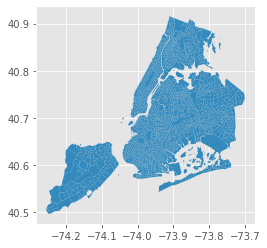

In [237]:
censustract.plot()

In [238]:
!wget https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip

--2020-11-22 02:24:49--  https://data.cityofnewyork.us/download/i8iw-xf4u/application%2Fzip
Resolving data.cityofnewyork.us (data.cityofnewyork.us)... 52.206.68.26, 52.206.140.199, 52.206.140.205
Connecting to data.cityofnewyork.us (data.cityofnewyork.us)|52.206.68.26|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip [following]
--2020-11-22 02:24:49--  https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
Reusing existing connection to data.cityofnewyork.us:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/octet-stream]
Saving to: ‘application%2Fzip.29’

application%2Fzip.2     [ <=>                ]   1.44M  --.-KB/s    in 0.08s   

2020-11-22 02:24:49 (19.0 MB/s) - ‘application%2Fzip.29’ saved [1514401]



In [239]:
!unzip application%2Fzip

Archive:  application%2Fzip
replace ZIP_CODE_040114.shx? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: ZIP_CODE_040114.shx     
  inflating: ZIP_CODE_040114.dbf     
  inflating: ZIP_CODE_040114.prj     
  inflating: ZIP_CODE_040114.sbn     
  inflating: ZIP_CODE_040114.sbx     
  inflating: ZIP_CODE_040114.shp     
  inflating: ZIP_CODE_040114.shp.xml  


In [240]:

zipcode = gpd.GeoDataFrame.from_file("ZIP_CODE_040114.shp")
zipcode

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."
2,11212,0,Brooklyn,83866.0,4.197210e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1011174.276 183696.338, 1011373.584 ..."
3,11225,0,Brooklyn,56527.0,2.369863e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995908.365 183617.613, 996522.848 18..."
4,11218,0,Brooklyn,72280.0,3.686880e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((991997.113 176307.496, 992042.798 17..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,10310,0,Staten Island,25003.0,5.346328e+07,NY,Richmond,36,085,http://www.usps.com/,0.0,0.0,"POLYGON ((950767.507 172848.969, 950787.510 17..."
259,11693,0,Far Rockaway,11052.0,3.497516e+06,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1028453.995 167153.410, 1027813.010 ..."
260,11249,0,Brooklyn,28481.0,1.777221e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((995877.318 203206.075, 995968.511 20..."
261,10162,1,New York,0.0,2.103489e+04,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((997731.761 219560.922, 997641.948 21..."


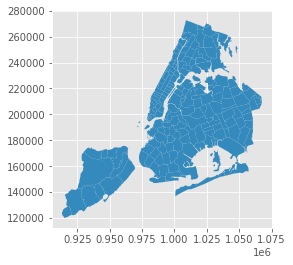

In [241]:
zipcode.plot()

In [242]:
# -- Make geoid before spatial join
zipcode["state"] = zipcode["ST_FIPS"].astype(str)
zipcode["county"] = zipcode["CTY_FIPS"].astype(str)
censustract["tract"] = censustract["boro_ct2010"].str[1:]

In [243]:
censustract.columns

Index(['ntacode', 'shape_area', 'ntaname', 'shape_leng', 'boro_name', 'puma',
       'ct2010', 'boro_code', 'cdeligibil', 'boro_ct2010', 'ctlabel',
       'geometry', 'tract'],
      dtype='object')

In [244]:
# Convert census tract data to centroid geometry.
censustract['geometry'] = censustract.geometry.centroid

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [245]:
censustract.columns

Index(['ntacode', 'shape_area', 'ntaname', 'shape_leng', 'boro_name', 'puma',
       'ct2010', 'boro_code', 'cdeligibil', 'boro_ct2010', 'ctlabel',
       'geometry', 'tract'],
      dtype='object')

In [246]:
# Spatial join of 2000 & 2010 census tract centroids to zipcodes.
censustract_zipcode = gpd.sjoin(left_df=censustract[["shape_leng",	"boro_name",	"ct2010", "geometry", "tract"]],
             right_df=zipcode[["ZIPCODE",	"POPULATION", "geometry", "state", "county"]].to_crs(censustract.crs),
             how='right', op='intersects', 
             lsuffix='00', rsuffix='zc')

In [247]:
censustract_zipcode.columns

Index(['index_00', 'shape_leng', 'boro_name', 'ct2010', 'tract', 'ZIPCODE',
       'POPULATION', 'geometry', 'state', 'county'],
      dtype='object')

In [248]:
censustract_zipcode['id'] = censustract_zipcode['state'] + censustract_zipcode['county'] + censustract_zipcode['tract']
censustract_zipcode = censustract_zipcode.dropna()
censustract_zipcode

,index_00,shape_leng,boro_name,ct2010,tract,ZIPCODE,POPULATION,geometry,state,county,id
0,409.0,6323.59663386,Queens,019000,019000,11436,18681.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",36,081,36081019000
0,573.0,6955.46452797,Queens,018800,018800,11436,18681.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",36,081,36081018800
0,575.0,8038.55967977,Queens,019200,019200,11436,18681.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",36,081,36081019200
0,1168.0,7150.59389471,Queens,018402,018402,11436,18681.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",36,081,36081018402
0,1180.0,7087.16640819,Queens,018200,018200,11436,18681.0,"POLYGON ((-73.80585 40.68291, -73.80569 40.682...",36,081,36081018200
...,...,...,...,...,...,...,...,...,...,...,...
260,1609.0,5664.39969841,Brooklyn,054700,054700,11249,28481.0,"POLYGON ((-73.95805 40.72442, -73.95772 40.724...",36,047,36047054700
260,1862.0,7343.45091916,Brooklyn,055500,055500,11249,28481.0,"POLYGON ((-73.95805 40.72442, -73.95772 40.724...",36,047,36047055500
260,1867.0,6845.7755595,Brooklyn,054900,054900,11249,28481.0,"POLYGON ((-73.95805 40.72442, -73.95772 40.724...",36,047,36047054900
260,1881.0,7122.6772057,Brooklyn,055100,055100,11249,28481.0,"POLYGON ((-73.95805 40.72442, -73.95772 40.724...",36,047,36047055100


#9. Merge all zipcode level df

In [249]:
# Join mean of spatial join results to zipcodes.
#meanzip = censustract_zipcode.groupby("ZIPCODE").mean()
#meanzip

In [250]:
geobiz.columns

Index(['ZIPCODE', 'geometry', 'name', 'est2000', 'est2010', 'area', 'logarea',
       'density2000', 'density2010', 'diff'],
      dtype='object')

In [251]:
#meangeobiz = geobiz.groupby("ZIPCODE").mean()
#meangeobiz

## dataframe cleanup 

In [252]:
# clean up all dataframes related to zipcode
#meanzip_meangeobiz = meanzip.merge(meangeobiz, left_on="ZIPCODE", right_on = "ZIPCODE")
#zipcode_meanzip_meangeobiz = zipcode.merge(meanzip_meangeobiz, left_on="ZIPCODE", right_on="ZIPCODE")
#zipcode_meanzip_meangeobiz.columns
#zipcode_meanzip_meangeobiz["GEOID"] = zipcode_meanzip_meangeobiz["state"] + zipcode_meanzip_meangeobiz["county"] + zipcode_meanzip_meangeobiz["tract"]
#zipcode_all = zipcode_meanzip_meangeobiz.fillna(0).copy()
#zipcode_all.columns
#zipcode_sub = zipcode_all[['ZIPCODE', 'GEOID', 'boro_name', 'shape_leng', 'POPULATION_x', 'geometry', 'est2000', 'est2010', 'area', 'logarea', 'density2000','density2010', 'diff']]
#len(zipcode_sub)

In [253]:
censustract_zipcode.columns

Index(['index_00', 'shape_leng', 'boro_name', 'ct2010', 'tract', 'ZIPCODE',
       'POPULATION', 'geometry', 'state', 'county', 'id'],
      dtype='object')

In [254]:
geobiz.columns

Index(['ZIPCODE', 'geometry', 'name', 'est2000', 'est2010', 'area', 'logarea',
       'density2000', 'density2010', 'diff'],
      dtype='object')

In [255]:
geometry_merge = censustract_zipcode.merge(geobiz, left_on="geometry", right_on = "geometry")
geometry_merge

,index_00,shape_leng,boro_name,ct2010,tract,ZIPCODE_x,POPULATION,geometry,state,county,id,ZIPCODE_y,name,est2000,est2010,area,logarea,density2000,density2010,diff


In [256]:
zipcode_merge = censustract_zipcode.merge(geobiz, left_on="ZIPCODE", right_on = "ZIPCODE")
len(zipcode_merge)
zipcode_merge.columns

Index(['index_00', 'shape_leng', 'boro_name', 'ct2010', 'tract', 'ZIPCODE',
       'POPULATION', 'geometry_x', 'state', 'county', 'id', 'geometry_y',
       'name', 'est2000', 'est2010', 'area', 'logarea', 'density2000',
       'density2010', 'diff'],
      dtype='object')

In [257]:
data00 = zipcode_merge.merge(ctract_data00, left_on="id", right_on="id")
data00.columns

Index(['index_00', 'shape_leng_x', 'boro_name_x', 'ct2010', 'tract_x',
       'ZIPCODE', 'POPULATION', 'geometry_x', 'state', 'county', 'id',
       'geometry_y', 'name', 'est2000', 'est2010', 'area', 'logarea',
       'density2000', 'density2010', 'diff', 'geometry', 'boro_name_y',
       'shape_area', 'shape_leng_y', 'label', 'Population', 'MedianAge',
       'PercWhite', 'PercNotWhite', 'borough', 'census_tract', 'median_income',
       'tract_y'],
      dtype='object')

In [258]:
# Merge zipcode dataframe to census dataframe (2000)
data00 = zipcode_merge.merge(ctract_data00, left_on="id", right_on="id")
data00.columns
data00 = data00[['ZIPCODE', 'id', 'label','borough', 'shape_leng_x','shape_area',
       'geometry_x', 'est2000', 'est2010', 'area', 'logarea', 'density2000',
       'density2010', 'diff', 'Population', 'MedianAge', 'PercNotWhite', 'median_income']]
data00.rename(columns = { 'shape_leng_x':'shape_leng', 'geometry_x':'geometry'}, inplace=True) 
len(data00)

1958

In [259]:
# Merge zipcode dataframe to census dataframe (2010)
data10 = zipcode_merge.merge(ctract_data10, left_on="id", right_on="id")
data10.columns
data10 = data10[['ZIPCODE', 'id', 'label','borough', 'shape_leng_x','shape_area',
       'geometry_x', 'est2000', 'est2010', 'area', 'logarea', 'density2000',
       'density2010', 'diff', 'Population', 'MedianAge', 'PercWhite','PercNotWhite', 'median_income']]
data10.rename(columns = {'shape_leng_x':'shape_leng', 'geometry_x':'geometry'}, inplace=True) 
len(data10)

2199

In [260]:
# Merge census dataframe (All)
cdata0010 = ctract_data00.merge(ctract_data10, left_on = "id", right_on="id")
cdata0010.columns
cdata0010 = cdata0010[['geoid', 'geometry_x', 'boro_name_x', 'shape_area_x', 'shape_leng_x',
           'label_x', 'Population_x', 'MedianAge_x', 'PercNotWhite_x', 'median_income_x', 
           'Population_y', 'MedianAge_y', 'PercNotWhite_y', 'median_income_y','borough_y']]
cdata0010.rename(columns = {'geoid':'id', 'geometry_x':'geometry', 'boro_name_x':'boro_name', 
                            'shape_area_x': 'shape_area', 'shape_leng_x':'shape_leng',
                            'label_x':'label', 'Population_x':'Population00', 'MedianAge_x':'MedianAge00', 
                            'PercNotWhite_x':'PercNotWhite00', 'median_income_x':'MedianIncome00',
                            'Population_y':'Population10', 'MedianAge_y':'MedianAge10', 
                            'PercNotWhite_y':'PercNotWhite10', 'median_income_y':'MedianIncome10',
                            'borough_y':'Borough'}, inplace=True) 
# Merge zipcode dataframe to census dataframe (All)
data_all = zipcode_merge.merge(cdata0010, left_on="id", right_on="id")
len(data_all)
data_all.columns
data_all = data_all[['ZIPCODE', 'id','label','Borough', 'shape_leng_x', 'shape_area', 'area', 'logarea', 
       'geometry_x', 'est2000', 'est2010', 'density2000',
       'density2010', 'diff', 'Population00', 'MedianAge00',
       'PercNotWhite00', 'MedianIncome00', 'Population10', 'MedianAge10',
       'PercNotWhite10', 'MedianIncome10']]
data_all.rename(columns = { 'shape_leng_x':'shape_leng', 'geometry_x':'geometry'}, inplace=True) 
data_all = data_all.fillna(0)
print(data_all.columns)
print(type(data_all))
print(len(data_all))

Index(['ZIPCODE', 'id', 'label', 'Borough', 'shape_leng', 'shape_area', 'area',
       'logarea', 'geometry', 'est2000', 'est2010', 'density2000',
       'density2010', 'diff', 'Population00', 'MedianAge00', 'PercNotWhite00',
       'MedianIncome00', 'Population10', 'MedianAge10', 'PercNotWhite10',
       'MedianIncome10'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
1958


In [261]:
data00 = GeoDataFrame(data00)
data10 = GeoDataFrame(data10)
data_all = GeoDataFrame(data_all)
type(data_all)

geopandas.geodataframe.GeoDataFrame

In [262]:
## new_file_name = "/content/drive/My Drive/mlpp20_group/data/clean_gtree_loc.shp"
## data = gtree_loc
## data.to_file(new_file_name)

#10. Cluster the census tracts on these four features (using a Eucledian distance and choosing whichever clustering model you want). Remember that before whitening you have to whiten (or standardize) the data

## use sklearn

https://github.com/fedhere/PUS2020_FBianco/blob/master/classdemo/kmeans.ipynb

## Standardize the data before whitening


In [263]:
def standardize_df(dataframe):
  frame_st = pd.DataFrame()
  df_cols = dataframe.columns.to_list()
  for i in df_cols:
    values=dataframe[i].astype(float)
    values_mean = values.mean()
    values_stdev = values.std()
    new_col_name = i+"_st"
    standardized_values=[]
    for x in values:
      standardized_values.append((x-values_mean)/values_stdev)
    frame_st[new_col_name] = standardized_values
  return frame_st

In [319]:
data00.columns

Index(['ZIPCODE', 'id', 'label', 'borough', 'shape_leng', 'shape_area',
       'geometry', 'est2000', 'est2010', 'area', 'logarea', 'density2000',
       'density2010', 'diff', 'Population', 'MedianAge', 'PercNotWhite',
       'median_income', 'cluster00', 'median_income_adj'],
      dtype='object')

In [320]:
data10.columns

Index(['ZIPCODE', 'id', 'label', 'borough', 'shape_leng', 'shape_area',
       'geometry', 'est2000', 'est2010', 'area', 'logarea', 'density2000',
       'density2010', 'diff', 'Population', 'MedianAge', 'PercWhite',
       'PercNotWhite', 'median_income', 'cluster10', 'median_income_adj',
       'median_income_2000_interp', 'income_diff_pred'],
      dtype='object')

In [321]:
# Extract values
data00.columns
data00_val = data00[['area', 'logarea', 'Population', 'MedianAge', 'PercNotWhite', 'median_income', 'est2000', 'density2000']]
data10.columns
data10_val = data00[['area', 'logarea', 'Population', 'MedianAge', 'PercNotWhite', 'median_income', 'est2010', 'density2010']]

# Standardize values and extract framework
data00_st = standardize_df(data00_val)
data10_st = standardize_df(data10_val)
data10_st

,area_st,logarea_st,Population_st,MedianAge_st,PercNotWhite_st,median_income_st,est2010_st,density2010_st
0,-0.596581,-0.798993,-0.657501,-0.322829,1.462566,-0.096719,-1.087065,-0.487937
1,-0.596581,-0.798993,-1.089063,0.266323,1.417823,0.211655,-1.087065,-0.487937
2,-0.596581,-0.798993,-0.759098,0.266323,1.456174,-0.031739,-1.087065,-0.487937
3,-0.596581,-0.798993,-0.675483,-0.096232,1.462566,0.532945,-1.087065,-0.487937
4,-0.596581,-0.798993,-0.652107,-0.368149,1.427411,-0.353333,-1.087065,-0.487937
...,...,...,...,...,...,...,...,...
1953,-0.689014,-1.125502,1.821730,-2.286669,-0.844891,-1.357012,-1.151201,-0.518873
1954,-0.689014,-1.125502,-0.145921,-2.362202,-0.931181,-1.259136,-1.151201,-0.518873
1955,-0.689014,-1.125502,-1.267981,-0.217084,-1.183659,0.507878,-1.151201,-0.518873
1956,-0.689014,-1.125502,-0.989264,-0.745810,-0.244057,-0.529867,-1.151201,-0.518873


In [322]:
# standaridze - another way
data_all["Pop00_st"] = (data00["Population"]-data00["Population"].mean())/data00["Population"].std()
data_all["Age00_st"] = (data00["MedianAge"]-data00["MedianAge"].mean())/data00["MedianAge"].std()
data_all["Div00_st"] = (data00["PercNotWhite"]-data00["PercNotWhite"].mean())/data00["PercNotWhite"].std()
data_all["Inc00_st"] = (data00["median_income"]-data00["median_income"].mean())/data00["median_income"].std()

data_all["Pop00_st"] = (data10["Population"]-data10["Population"].mean())/data10["Population"].std()
data_all["Age00_st"] = (data10["MedianAge"]-data10["MedianAge"].mean())/data10["MedianAge"].std()
data_all["Div00_st"] = (data10["PercNotWhite"]-data10["PercNotWhite"].mean())/data10["PercNotWhite"].std()
data_all["Inc00_st"] = (data10["median_income"]-data10["median_income"].mean())/data10["median_income"].std()
data_all.columns

Index(['ZIPCODE', 'id', 'label', 'Borough', 'shape_leng', 'shape_area', 'area',
       'logarea', 'geometry', 'est2000', 'est2010', 'density2000',
       'density2010', 'diff', 'Population00', 'MedianAge00', 'PercNotWhite00',
       'MedianIncome00', 'Population10', 'MedianAge10', 'PercNotWhite10',
       'MedianIncome10', 'Pop00_st', 'Age00_st', 'Div00_st', 'Inc00_st',
       'cluster00', 'cluster10', 'cluster_change'],
      dtype='object')

## First way is using sklearn.cluster.KMeans

### First way of using kmean clustering

In [330]:
data00 = data00.fillna(0)
data10 = data10.fillna(0)
data00_st = data00_st.fillna(0)
data10_st = data10_st.fillna(0)
len(data10_st)

1958

In [333]:
#kmeansmod00  = sklearn.cluster.KMeans(n_clusters=4).fit_predict(data00_st)
kmean4 = KMeans(n_clusters=4)
kmeansmod00 = kmean4.fit(data00_st)
#kmeansmod10  = sklearn.cluster.KMeans(n_clusters=4).fit_predict(data00_st)
kmeansmod10 = kmean4.fit(data10_st)
kmeansmod10

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [336]:
#data00["cluster00"] = pd.Series(kmeansmod00, index=data00_st.index)
#data10["cluster10"] = pd.Series(kmeansmod10, index=data00_st.index)
#data_all["cluster00"] = pd.Series(kmeansmod00, index=data00_st.index)
#data_all["cluster10"] = pd.Series(kmeansmod10, index=data00_st.index)
#data_all["cluster_change"] = data_all["cluster00"] - data_all["cluster10"]
#data_all.columns
#data00["cluster00"] = kmeansmod00.labels_
#data10["cluster10"] = kmeansmod10.labels_
data_all["cluster00"] = kmeansmod00.labels_
data_all["cluster10"] = kmeansmod10.labels_
data_all["cluster_change"] = data_all["cluster00"] - data_all["cluster10"]
data_all.columns

Index(['ZIPCODE', 'id', 'label', 'Borough', 'shape_leng', 'shape_area', 'area',
       'logarea', 'geometry', 'est2000', 'est2010', 'density2000',
       'density2010', 'diff', 'Population00', 'MedianAge00', 'PercNotWhite00',
       'MedianIncome00', 'Population10', 'MedianAge10', 'PercNotWhite10',
       'MedianIncome10', 'Pop00_st', 'Age00_st', 'Div00_st', 'Inc00_st',
       'cluster00', 'cluster10', 'cluster_change'],
      dtype='object')

### Second way of using kmean clustering
The codes below are for the reference

https://github.com/fedhere/PUS2020_FBianco/blob/master/classdemo/kmeans.ipynb

In [337]:
# Example
k1m, k2m, k1s, k2s = 9.8, 8.5, 1.1, 1.6
k1 = (k1s * np.random.randn(2, 100) + k1m).T
k2 = (k2s * np.random.randn(2, 100) + k2m).T
k1

array([[10.58457358,  8.34624974],
       [10.09925529,  6.8942624 ],
       [ 8.27579375,  8.42483997],
       [10.89310763,  8.34747069],
       [ 9.40794003, 11.30067215],
       [ 9.06393416, 11.7128162 ],
       [10.5139605 ,  9.734544  ],
       [11.80640049, 10.01220649],
       [ 9.03321776,  9.11091878],
       [ 8.82395771, 10.763757  ],
       [10.23643672, 10.11235097],
       [10.38961309,  9.24342565],
       [ 9.26650673, 10.86797027],
       [12.09850746,  9.12779854],
       [ 8.71515696, 10.19879192],
       [ 9.97063521,  7.16414149],
       [ 7.92748328,  7.69792169],
       [10.03516635, 10.20719885],
       [ 9.21705301,  9.29963242],
       [ 8.86611242,  9.10304824],
       [ 9.0303074 , 10.1753911 ],
       [ 9.67624244,  9.80267661],
       [ 8.75463829, 10.8961581 ],
       [10.05783157, 10.49804249],
       [10.89897294,  8.84016505],
       [ 9.28021092, 11.51332436],
       [ 9.03133983, 10.3230937 ],
       [11.17178323,  8.6836814 ],
       [ 9.76054285,

In [338]:
k1[:,0]

array([10.58457358, 10.09925529,  8.27579375, 10.89310763,  9.40794003,
        9.06393416, 10.5139605 , 11.80640049,  9.03321776,  8.82395771,
       10.23643672, 10.38961309,  9.26650673, 12.09850746,  8.71515696,
        9.97063521,  7.92748328, 10.03516635,  9.21705301,  8.86611242,
        9.0303074 ,  9.67624244,  8.75463829, 10.05783157, 10.89897294,
        9.28021092,  9.03133983, 11.17178323,  9.76054285,  9.48848739,
        9.57513742,  7.94919436,  9.63064026, 10.63312518,  8.98122126,
        9.88559449,  9.55536003, 10.87497177,  9.3603629 , 11.57055832,
       10.5911746 , 10.20148864,  9.99512717, 12.70184214,  7.70015601,
       10.95850689, 10.16713199,  9.83726824,  9.73524185, 10.48876107,
        7.33501142,  9.92512209,  9.86207385,  9.799248  ,  9.96823806,
       11.40566719,  8.45580881,  9.28507508,  8.94053214,  7.44328491,
        8.53559772,  9.28548248,  8.53101852, 10.34706525, 10.25366632,
        9.80567906,  9.58569473,  9.71963553, 10.30942211,  9.81

In [339]:
k1[:,1]

array([ 8.34624974,  6.8942624 ,  8.42483997,  8.34747069, 11.30067215,
       11.7128162 ,  9.734544  , 10.01220649,  9.11091878, 10.763757  ,
       10.11235097,  9.24342565, 10.86797027,  9.12779854, 10.19879192,
        7.16414149,  7.69792169, 10.20719885,  9.29963242,  9.10304824,
       10.1753911 ,  9.80267661, 10.8961581 , 10.49804249,  8.84016505,
       11.51332436, 10.3230937 ,  8.6836814 , 10.03210955, 10.47021905,
       12.09811684,  9.88998261, 13.60627074, 10.6459595 ,  9.24139748,
       11.78217117,  9.84773032,  9.25056122, 10.58311074, 10.76616515,
        9.87665904,  7.8602847 ,  8.98095739,  7.53104594,  9.76868151,
       10.30133322, 10.0878843 , 10.2840914 ,  9.52625456, 10.7100647 ,
        9.53285783,  9.56236285,  8.5711337 ,  8.77117691, 10.06230466,
       10.48290843,  7.14210945,  9.57660571,  9.37908044,  9.33396463,
        8.93532433,  9.18187749,  9.030109  ,  9.4255994 , 10.49296316,
       11.36755915,  8.91771254,  8.98511873, 10.53450521,  9.45

In [340]:
from geopandas import GeoDataFrame
%matplotlib inline
from shapely.geometry import Point, LineString
from shapely.geometry import shape

In [341]:
!pip install centroid

In [342]:
import fiona
from shapely.geometry import shape
import numpy as np

In [343]:
import numpy as np
from shapely.geometry import Point

In [344]:
# Extract the point values that define the perimeter of the polygon
#https://gis.stackexchange.com/questions/252764/converting-a-list-of-shapely-geometry-to-numpy-array

feat = data_all.copy()
feat["geometry_point"] = feat["geometry"].centroid
feat.head()

mypoints = [feat["geometry_point"]]
mypoints

listarray = []
for pp in mypoints:
    listarray.append([pp.x, pp.y])
nparray = np.array(listarray)
nparray

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


array([[[-73.79650291, -73.79650291, -73.79650291, ..., -73.96283166,
         -73.96283166, -73.96283166],
        [ 40.67587193,  40.67587193,  40.67587193, ...,  40.71301599,
          40.71301599,  40.71301599]]])

In [345]:
np.array(pp.x)

array([-73.79650291, -73.79650291, -73.79650291, ..., -73.96283166,
       -73.96283166, -73.96283166])

In [346]:
#http://taewan.kim/post/transpose_reshape/
np.arange(1,9)

array([1, 2, 3, 4, 5, 6, 7, 8])

In [347]:
np.arange(1,9).reshape((2,4))

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [348]:
np.arange(1,9).reshape(((2,2,2)))

array([[[1, 2],
        [3, 4]],

       [[5, 6],
        [7, 8]]])

In [349]:
a = np.arange(1,13).reshape(((2,1,6)))
a

array([[[ 1,  2,  3,  4,  5,  6]],

       [[ 7,  8,  9, 10, 11, 12]]])

In [350]:
a.reshape(((6,1,2)))

array([[[ 1,  2]],

       [[ 3,  4]],

       [[ 5,  6]],

       [[ 7,  8]],

       [[ 9, 10]],

       [[11, 12]]])

In [351]:
a.reshape((6,2))

array([[ 1,  2],
       [ 3,  4],
       [ 5,  6],
       [ 7,  8],
       [ 9, 10],
       [11, 12]])

In [352]:
nparray.T.reshape((1958,2))

array([[-73.79650291,  40.67587193],
       [-73.79650291,  40.67587193],
       [-73.79650291,  40.67587193],
       ...,
       [-73.96283166,  40.71301599],
       [-73.96283166,  40.71301599],
       [-73.96283166,  40.71301599]])

In [353]:
from shapely.geometry import shape

# Extract the point values that define the perimeter of the polygon

# data00
feat00 = data00.copy()
feat00["geometry_point"] = feat00["geometry"].centroid
mypoints00 = [feat00["geometry_point"]]
mypoints00

listarray00 = []
for pp in mypoints00:
    listarray00.append([pp.x, pp.y])
nparray00 = np.array(listarray00)

nparray00 = nparray00.T.reshape((1958,2))
nparray00

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys


array([[-73.79650291,  40.67587193],
       [-73.79650291,  40.67587193],
       [-73.79650291,  40.67587193],
       ...,
       [-73.96283166,  40.71301599],
       [-73.96283166,  40.71301599],
       [-73.96283166,  40.71301599]])

In [354]:
4398 / 2

2199.0

In [355]:
# data10
feat10 = data10.copy()
feat10["geometry_point"] = feat10["geometry"].centroid
mypoints10 = [feat10["geometry_point"]]
mypoints10

listarray10 = []
for pp in mypoints10:
    listarray10.append([pp.x, pp.y])
nparray10 = np.array(listarray10)

nparray10 = nparray10.T.reshape((2199,2))
nparray10

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


array([[-73.79650291,  40.67587193],
       [-73.79650291,  40.67587193],
       [-73.79650291,  40.67587193],
       ...,
       [-73.96283166,  40.71301599],
       [-73.96283166,  40.71301599],
       [-73.96283166,  40.71301599]])

In [356]:
k1 = nparray00
k2 = nparray10
X = np.concatenate([k1, k2])
#Xscale = sklearn.preprocessing.scale(X, axis=0 )
kmeansmod  = sklearn.cluster.KMeans(n_clusters=2).fit(X)
kmeansmod.labels_

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [357]:
kmeansmod.cluster_centers_

array([[-73.86308679,  40.76982545],
       [-73.9773645 ,  40.65105228]])

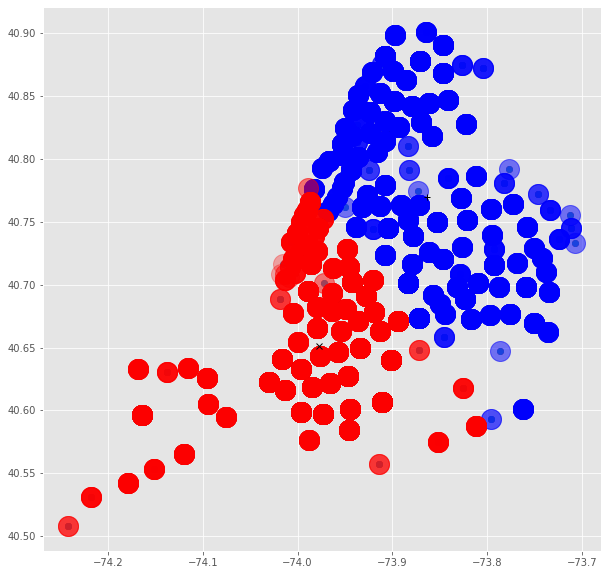

In [358]:
pl.figure(figsize = (10,10))
pl.plot(k1[:,0], k1[:,1], 'o')
pl.plot(k2[:,0], k2[:,1], 'o')


pl.plot(X[kmeansmod.labels_ == 0][:,0], X[kmeansmod.labels_ == 0][:,1], 'bo', ms=20, alpha = 0.3)
pl.plot(X[kmeansmod.labels_ == 1][:,0], X[kmeansmod.labels_ == 1][:,1],'ro', ms=20, alpha = 0.3)
pl.plot(kmeansmod.cluster_centers_[1,0], kmeansmod.cluster_centers_[1,1], 'kx')
pl.plot(kmeansmod.cluster_centers_[0,0], kmeansmod.cluster_centers_[0,1], 'k+')


the true centers are: -73.98 40.65 -73.86 40.77


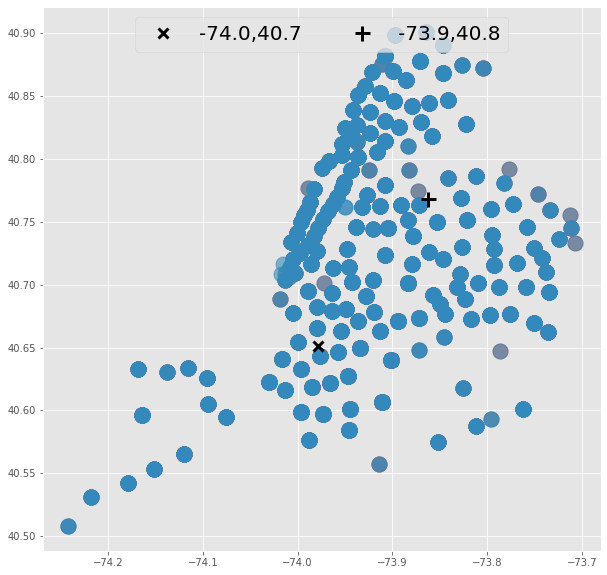

In [359]:
x0 = -73.97896136
y0 = 40.65145126
x1 = -73.86206665
y1 = 40.76802041

x_save = (x0,x1)
y_save = (y0,y1)

print ("the true centers are: {:.2f} {:.2f} {:.2f} {:.2f}".format(x0,y0,x1,y1))

# Figure
pl.figure(figsize = (10,10))
pl.plot(k1[:,0], k1[:,1], 'o', ms = 15, alpha=0.6)
pl.plot(k2[:,0], k2[:,1], 'o', ms = 15, alpha=0.6)

pl.plot([x0], [y0], 'kx', ms = 10, mew=3, label="%.1f,%.1f"%(x0,y0))
pl.plot([x1], [y1], 'k+', ms = 15, mew=3, label="%.1f,%.1f"%(x1,y1))
pl.legend(loc = 'upper center', ncol= 2, numpoints=1, fontsize=20)

## When using Eucledian distance

In [360]:
def dist (data, c):
    return (data[0]-c[0])**2 + (data[1]-c[1])**2

In [361]:
l1 = np.zeros(len(k1), int)
for i,k in enumerate(k1):
    l1[i] = 0 if dist(k, [x0, y0]) < dist(k, [x1, y1]) else 1
l2 = np.zeros(len(k2), int)
for i,k in enumerate(k2):
    l2[i] = 0 if dist(k, [x0, y0]) < dist(k, [x1, y1]) else 1

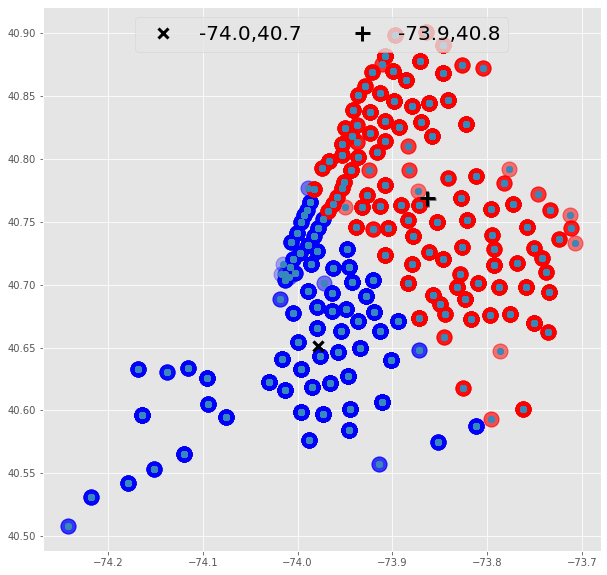

In [362]:
pl.figure(figsize = (10,10))

pl.plot([x0], [y0], 'kx', ms = 10, mew=3, alpha=0.5)
pl.plot([x1], [y1], 'k+', ms = 15, mew=3, alpha=0.5)

pl.plot(k1[l1==0][:,0], k1[l1==0][:,1], 'bo', ms=15, alpha = 0.3)
pl.plot(k2[l2==0][:,0], k2[l2==0][:,1], 'bo', ms=15, alpha = 0.3)
pl.plot(k1[l1==1][:,0], k1[l1==1][:,1], 'ro', ms=15, alpha = 0.3)
pl.plot(k2[l2==1][:,0], k2[l2==1][:,1], 'ro', ms=15, alpha = 0.3)
pl.plot(k1[:,0], k1[:,1], 'o')
pl.plot(k2[:,0], k2[:,1], 'o')

xnew0, ynew0 = np.mean(np.concatenate([k1[l1==0][:,0], 
                                       k2[l2==0][:,0]])), np.mean(np.concatenate([k1[l1==0][:,1], 
                                                                                  k2[l2==0][:,1]]))
xnew1, ynew1 = np.mean(np.concatenate([k1[l1==1][:,0], 
                                       k2[l2==1][:,0]])), np.mean(np.concatenate([k1[l1==1][:,1], 
                                                                                  k2[l2==1][:,1]]))
pl.plot([xnew0], [ynew0], 'kx', ms = 10, mew=3, label="%.1f,%.1f"%(xnew0,ynew0))
pl.plot([xnew1], [ynew1], 'k+', ms = 15, mew=3, label="%.1f,%.1f"%(xnew1,ynew1))
pl.legend(loc = 'upper center', ncol= 2, numpoints=1, fontsize=20)

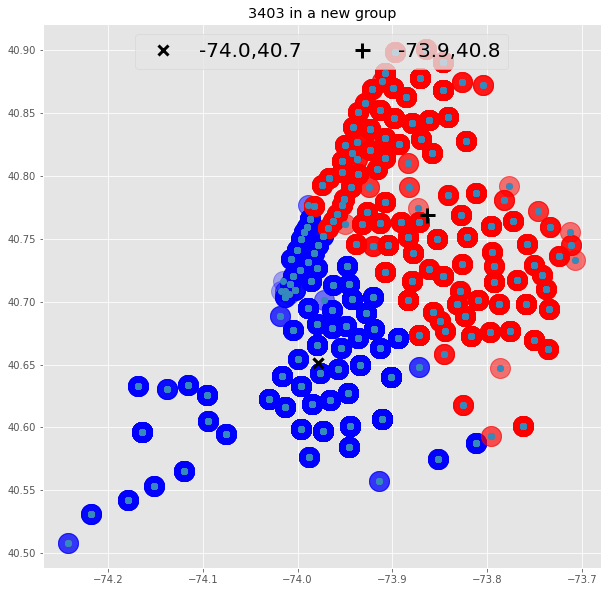

In [363]:
l1old = np.empty_like(l1)
l2old = np.empty_like(l2)

while not xnew0 == x0 or  not ynew0 == y0 or  not xnew1 == x1 or  not ynew1 == y1:
    pl.figure(figsize = (10,10))
    x0 = xnew0
    x1 = xnew1
    y0 = ynew0
    y1 = ynew1
    
    l1 = np.zeros(len(k1), int)
    for i,k in enumerate(k1):
        l1[i] = 0 if dist(k, [x0, y0]) < dist(k, [x1, y1]) else 1
    l2 = np.zeros(len(k2), int)
    for i,k in enumerate(k2):
        l2[i] = 0 if dist(k, [x0, y0]) < dist(k, [x1, y1]) else 1
        
        
    pl.plot([x0], [y0], 'kx', ms = 10, mew=3, alpha=0.5)
    pl.plot([x1], [y1], 'y+', ms = 15, mew=3, alpha=0.5)

    pl.plot(k1[l1==0][:,0], k1[l1==0][:,1], 'bo', ms=20, alpha = 0.3)
    pl.plot(k2[l2==0][:,0], k2[l2==0][:,1], 'bo', ms=20, alpha = 0.3)
    pl.plot(k1[l1==1][:,0], k1[l1==1][:,1], 'ro', ms=20, alpha = 0.3)
    pl.plot(k2[l2==1][:,0], k2[l2==1][:,1], 'ro', ms=20, alpha = 0.3)
    pl.plot(k1[:,0], k1[:,1], 'o')
    pl.plot(k2[:,0], k2[:,1], 'o')

    xnew0, ynew0 = np.mean(np.concatenate([k1[l1==0][:,0], 
                                       k2[l2==0][:,0]])), np.mean(np.concatenate([k1[l1==0][:,1], 
                                                                                  k2[l2==0][:,1]]))
    xnew1, ynew1 = np.mean(np.concatenate([k1[l1==1][:,0], 
                                       k2[l2==1][:,0]])), np.mean(np.concatenate([k1[l1==1][:,1], 
                                                                                  k2[l2==1][:,1]]))
    pl.plot([xnew0], [ynew0], 'kx', ms = 10, mew=3, label="%.1f,%.1f"%(xnew0,ynew0))
    pl.plot([xnew1], [ynew1], 'k+', ms = 15, mew=3, label="%.1f,%.1f"%(xnew1,ynew1))
    pl.legend(loc = 'upper center', ncol= 2, numpoints=1, fontsize=20)
    pl.title("%d in a new group"%(sum(~(
                    l1old == l1))+sum(~(l2old == l2))))
    l1old = l1
    l2old = l2

In [364]:
print ("the original centers were:  %.1f %.1f, %.1f %.1f"%(x_save[0], y_save[0], 
                                                         x_save[1], y_save[1]))
print ("the new K-means center are: %.1f %.1f, %.1f %.1f"%(xnew0, ynew0, 
                                                         xnew1, ynew1))

the original centers were:  -74.0 40.7, -73.9 40.8
the new K-means center are: -74.0 40.7, -73.9 40.8


In [365]:
print ("the original centers were:  %.1f %.1f, %.1f %.1f"%(x_save[0], y_save[0], 
                                                         x_save[1], y_save[1]))
print ("the new K-means center are: %.1f %.1f, %.1f %.1f"%(xnew0, ynew0, 
                                                         xnew1, ynew1))

the original centers were:  -74.0 40.7, -73.9 40.8
the new K-means center are: -74.0 40.7, -73.9 40.8


#11. Identify the census tracts that have changed cluster assignment (those that are now associated with a different group of census tracts) and show a choropleth of the clusters in 2010, 2000 and a choropleth of the cluster changes. (Once you get through this, you have done most of the heavy lifting! The rest is building upon this work.)

In [366]:
data_all.columns

Index(['ZIPCODE', 'id', 'label', 'Borough', 'shape_leng', 'shape_area', 'area',
       'logarea', 'geometry', 'est2000', 'est2010', 'density2000',
       'density2010', 'diff', 'Population00', 'MedianAge00', 'PercNotWhite00',
       'MedianIncome00', 'Population10', 'MedianAge10', 'PercNotWhite10',
       'MedianIncome10', 'Pop00_st', 'Age00_st', 'Div00_st', 'Inc00_st',
       'cluster00', 'cluster10', 'cluster_change'],
      dtype='object')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries t

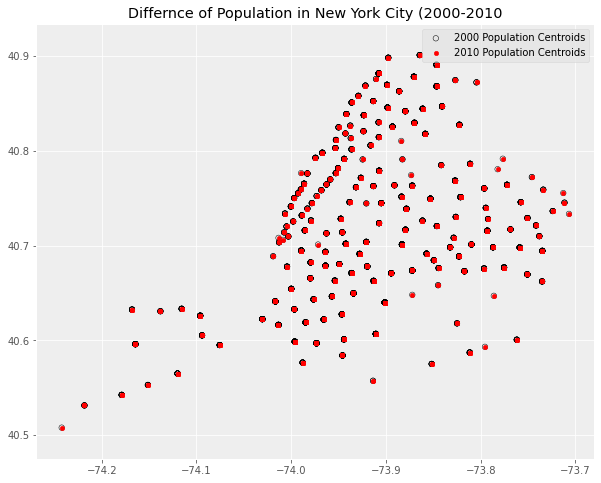

In [367]:
# Population

data00_pop = data_all[['ZIPCODE', 'id', 'geometry', 'Population00']]
data10_pop = data_all[['ZIPCODE', 'id', 'geometry', 'Population10']]

lon00_pop  = data00_pop.centroid.x
lat00_pop  = data00_pop.centroid.y

lon10_pop  = data10_pop.centroid.x
lat10_pop  = data10_pop.centroid.y

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(lon00_pop, lat00_pop, facecolor="none", color="k", s=30, label="2000 Population Centroids")
ax.scatter(lon10_pop, lat10_pop, c="r", s=20, label="2010 Population Centroids")
ax.set_facecolor("#EEEEEE")
ax.legend()
ax.axis("equal")
plt.title("Differnce of Population in New York City (2000-2010")
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries t

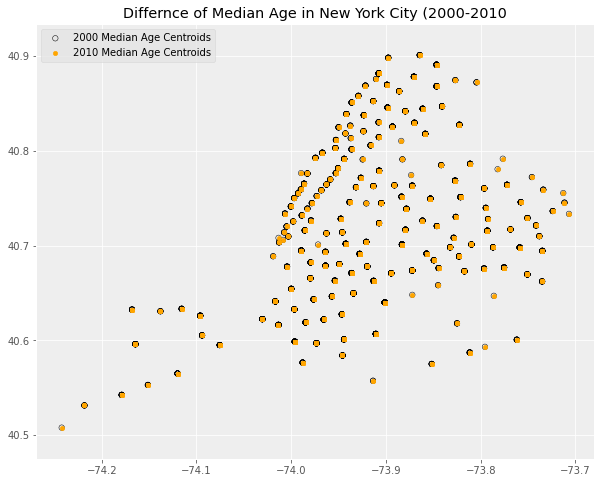

In [368]:
# Median Age

data00_age = data_all[['ZIPCODE', 'id', 'geometry', 'MedianAge00']]
data10_age = data_all[['ZIPCODE', 'id', 'geometry', 'MedianAge10']]

lon00  = data00_age.centroid.x
lat00  = data00_age.centroid.y

lon10  = data10_age.centroid.x
lat10  = data10_age.centroid.y

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(lon00, lat00, facecolor="none", color="k", s=30, label="2000 Median Age Centroids")
ax.scatter(lon10, lat10, c="orange", s=20, label="2010 Median Age Centroids")
ax.set_facecolor("#EEEEEE")
ax.legend()
ax.axis("equal")
plt.title("Differnce of Median Age in New York City (2000-2010")
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries t

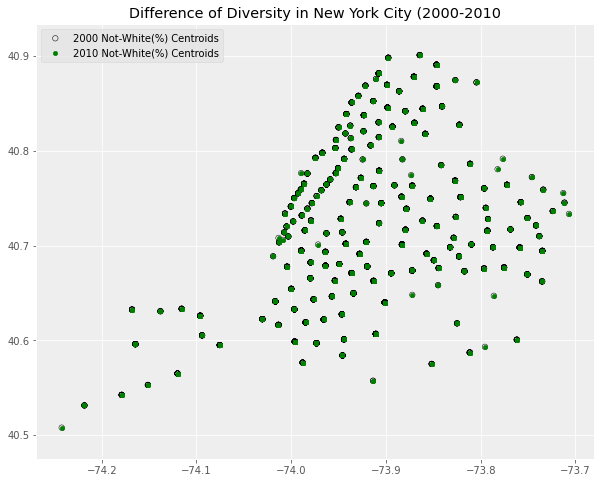

In [369]:
# Perc Not White (Diversity)

data00_div = data_all[['ZIPCODE', 'id', 'geometry', 'PercNotWhite00']]
data10_div = data_all[['ZIPCODE', 'id', 'geometry', 'PercNotWhite10']]

lon00  = data00_div.centroid.x
lat00  = data00_div.centroid.y

lon10  = data10_div.centroid.x
lat10  = data10_div.centroid.y

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(lon00, lat00, facecolor="none", color="k", s=30, label="2000 Not-White(%) Centroids")
ax.scatter(lon10, lat10, c="green", s=20, label="2010 Not-White(%) Centroids")
ax.set_facecolor("#EEEEEE")
ax.legend()
ax.axis("equal")
plt.title("Difference of Diversity in New York City (2000-2010")
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries t

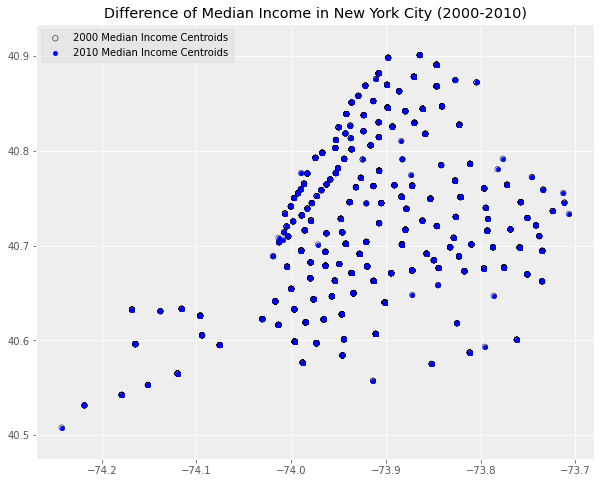

In [370]:
# Median Income

data00_inc = data_all[['ZIPCODE', 'id', 'geometry', 'MedianIncome00']]
data10_inc = data_all[['ZIPCODE', 'id', 'geometry', 'MedianIncome10']]

lon00  = data00_inc.centroid.x
lat00  = data00_inc.centroid.y

lon10  = data10_inc.centroid.x
lat10  = data10_inc.centroid.y

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(lon00, lat00, facecolor="none", color="k", s=30, label="2000 Median Income Centroids")
ax.scatter(lon10, lat10, c="blue", s=20, label="2010 Median Income Centroids")
ax.set_facecolor("#EEEEEE")
ax.legend()
ax.axis("equal")
plt.title("Difference of Median Income in New York City (2000-2010)")
fig.show()

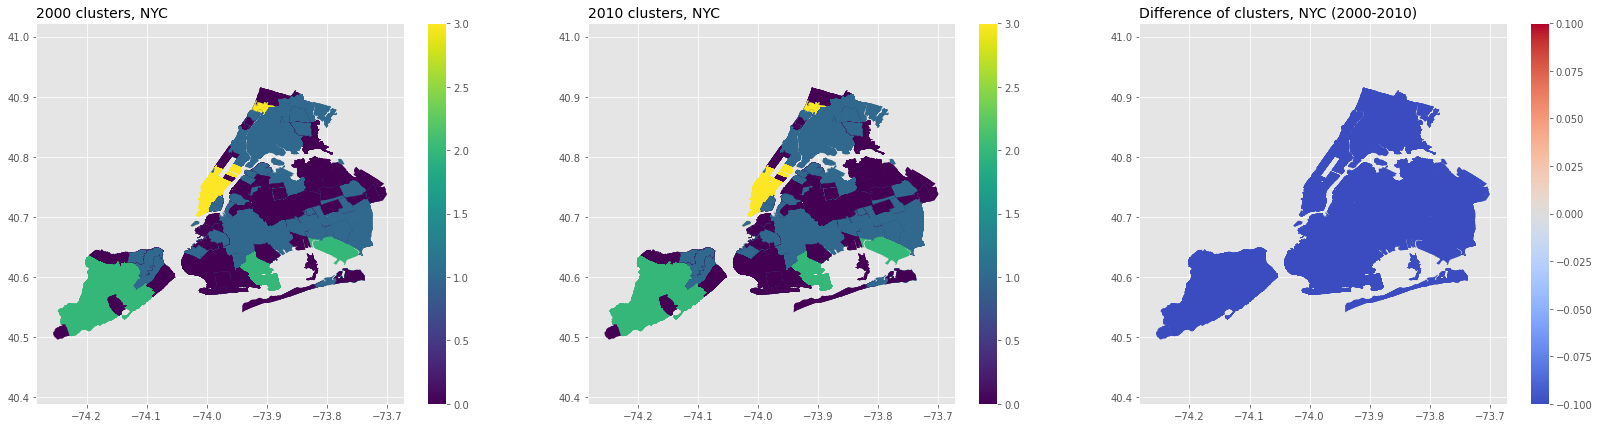

In [371]:
# "All-in-one" cluster
fig, ax = plt.subplots(1,3, figsize=[28,7])
plot0 = ax[0]
plot1 = ax[1]
plot2 = ax[2]

data_all.plot("cluster00", legend=True, ax=plot0)
ax[0].axis("equal")
ax[0].set_title("2000 clusters, NYC", loc="left", fontsize=14)

data_all.plot("cluster10", legend=True, ax=plot1)
ax[1].axis("equal")
ax[1].set_title("2010 clusters, NYC", loc="left", fontsize=14)

data_all.plot("cluster_change", legend=True, ax=plot2, cmap="coolwarm")
ax[2].axis("equal")
ax[2].set_title("Difference of clusters, NYC (2000-2010)", loc="left", fontsize=14)

fig.show()

## Extra: use gaussian process regressor
This is a reviewe of Machine Learning for Public Policy class for myself
https://github.com/KLeeDE/Machine-Learning/blob/master/Outcomes%20of%20gentrification_local%20changes%20to%20median%20income.ipynb

In [372]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [373]:
# -- create features and target arrays
lon00  = data00.centroid.x
lat00  = data00.centroid.y

lon10  = data10.centroid.x
lat10  = data10.centroid.y

ratio = data10["median_income"].mean() / data00["median_income"].mean()
data00["median_income_adj"] = data00["median_income"] * ratio
ratio = data10["median_income"].mean() / data00["median_income"].mean()
data10["median_income_adj"] = data10["median_income"] * ratio

pos00 = np.vstack([lon00, lat00]).T
wf00 = data00["median_income_adj"].values.copy()
pos10 = np.vstack([lon10, lat10]).T
wf10 = data10["median_income_adj"].values.copy()

# -- Standardize the features array across objects
pos00m = pos00.mean(0)
pos00s = pos00.std(0)
wf00m = wf00.mean()
wf00s = wf00.std()

pos00 -= pos00m
pos00 /= pos00s
wf00 -= wf00m
wf00 /= wf00s

pos10m = pos10.mean(0)
pos10s = pos10.std(0)
wf10m = wf10.mean()
wf10s = wf10.std()

pos10 -= pos10m
pos10 /= pos10s
wf10 -= wf10m
wf10 /= wf10s

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'G

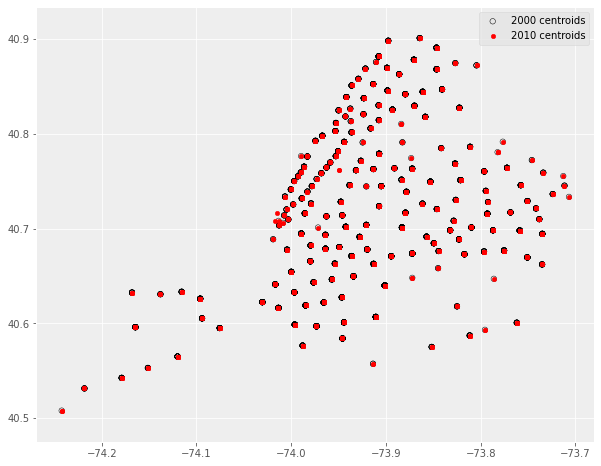

In [374]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(lon00, lat00, facecolor="none", color="k", s=30, label="2000 centroids")
ax.scatter(lon10, lat10, c="r", s=20, label="2010 centroids")
ax.set_facecolor("#EEEEEE")
ax.legend()
ax.axis("equal")
fig.show()

In [375]:
# -- now we initialize the kernel and fit to the data
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

gpr.fit(pos00, wf00)

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=10),
                         n_restarts_optimizer=10, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

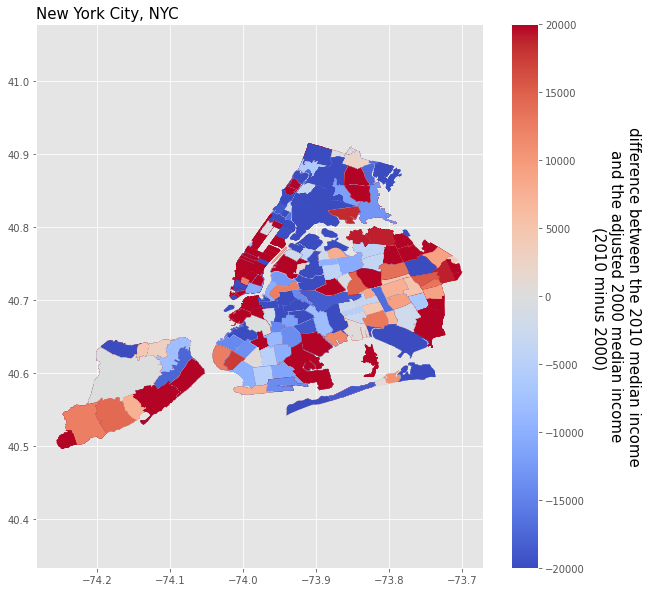

In [376]:
#Interpolate the trained model onto these positions using the `.predict()` method.
# -- predict
wf10pred = gpr.predict(pos10)

# -- now un-standardize and reattatch to the GeoDF
data10["median_income_2000_interp"] = wf10pred * wf00s + wf00m
data10["income_diff_pred"] = data10["median_income"] - data10["median_income_2000_interp"]

# -- make a choropleth
fig, ax = plt.subplots(figsize=[10, 10])
data10.plot("income_diff_pred", cmap="coolwarm", vmin=-20000, vmax=20000, legend=True, ax=ax)
ax.axis("equal")
ax.set_title("New York City, NYC", loc="left", fontsize=15)
fig.text(0.93, 0.5, "difference between the 2010 median income \nand the adjusted 2000 median income \n(2010 minus 2000)", ha="center", 
         va="center", rotation=-90, fontsize=15)
fig.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/_gpr.py:494: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


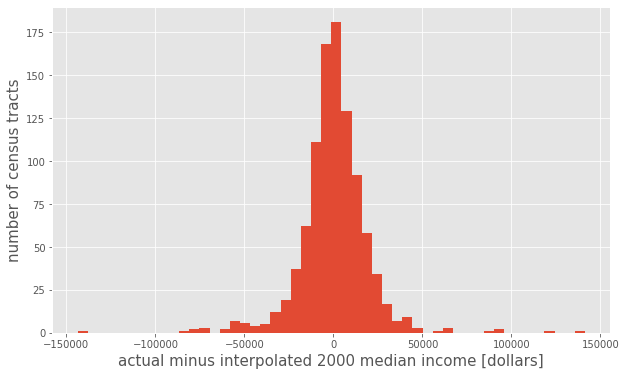

In [377]:
# -- create features and target arrays
lon00  = data00.centroid.x
lat00  = data00.centroid.y
pos00 = np.vstack([lon00, lat00]).T
wf00 = data00["median_income_adj"].values.copy()

# -- select every other census tract to split into two samples
pos00_0 = pos00[::2].copy()
wf00_0 = wf00[::2].copy()
pos00_1 = pos00[1::2].copy()
wf00_1 = wf00[1::2].copy()

# -- standardize (in units of the first sample)
pos00_0st = (pos00_0 - pos00_0.mean(axis=0, keepdims=True)) / pos00_0.std(axis=0, keepdims=True)
wf00_0st = (wf00_0 - wf00_0.mean()) / wf00_0.std()
pos00_1st = (pos00_1 - pos00_0.mean(axis=0, keepdims=True)) / pos00_0.std(axis=0, keepdims=True)
wf00_1st = (wf00_1 - wf00_0.mean()) / wf00_0.std()

# -- fit a Gaussian Process Regressor to first half
kernel   = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpr_half = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gpr_half.fit(pos00_0st, wf00_0st)

# -- predict second half
pred00_1st = gpr_half.predict(pos00_1st)

# -- unstandardize the prediction
pred00_1 = pred00_1st * wf00_0.std() + wf00_0.mean()

# -- take the difference between the prediction and the target
diff00_1 = wf00_1 - pred00_1

# -- plot the histogram of differences
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(diff00_1, bins=50)
ax.set_xlabel("actual minus interpolated 2000 median income [dollars]", fontsize=15)
ax.set_ylabel("number of census tracts", fontsize=15)
fig.show()